# Part II: Autoencoders for Anomaly Detection [30 pts]
Implement autoencoder and explore its application for a real-world problem related to anomaly detection.
The final model should achieve a test accuracy of greater than 80%.

**Datasets:** Select ONE dataset based on your preference:
- Yahoo S5 Dataset
- Hard Drive Test Data
- Numenta Anomaly Benchmark

## Step 1: Data preparation

1. Select and load one dataset from the list above.

In [ ]:
!pip install torchinfo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from copy import deepcopy
import random

I have chosen the [NYC Taxi Dataset](https://www.kaggle.com/datasets/boltzmannbrain/nab?resource=download)


In [ ]:
nyc_taxi = pd.read_csv('nyc_taxi.csv', low_memory=False)

2. Analyze the dataset and provide the following statistics:
   - Number of samples (time points)
   - Number of features
   - Mean, standard deviation, minimum, and maximum values for each feature (or relevant descriptive statistics depending on the data type)

In [ ]:
nyc_taxi['timestamp'] = pd.to_datetime(nyc_taxi['timestamp'])
num_samples = len(nyc_taxi)
print(f"Number of samples (time points): {num_samples}")
num_features = len(nyc_taxi.columns)
print(f"Number of features: {num_features}")
print("\nDescriptive Statistics for Each Feature:")
print("\nFeature: timestamp")
print(f" - Earliest timestamp: {nyc_taxi['timestamp'].min()}")
print(f" - Latest timestamp: {nyc_taxi['timestamp'].max()}")
print(f" - Time span: {nyc_taxi['timestamp'].max() - nyc_taxi['timestamp'].min()}")
print("\nFeature: value")
value_stats = nyc_taxi['value'].describe()
mean_value = nyc_taxi['value'].mean()
std_value = nyc_taxi['value'].std()
min_value = nyc_taxi['value'].min()
max_value = nyc_taxi['value'].max()
print(f" - Mean: {mean_value:.2f}")
print(f" - Standard Deviation: {std_value:.2f}")
print(f" - Minimum: {min_value}")
print(f" - Maximum: {max_value}")
print(f" - Additional Stats (from describe):")
print(value_stats)

Number of samples (time points): 10320
Number of features: 2

Descriptive Statistics for Each Feature:

Feature: timestamp
 - Earliest timestamp: 2014-07-01 00:00:00
 - Latest timestamp: 2015-01-31 23:30:00
 - Time span: 214 days 23:30:00

Feature: value
 - Mean: 15137.57
 - Standard Deviation: 6939.50
 - Minimum: 8
 - Maximum: 39197
 - Additional Stats (from describe):
count    10320.000000
mean     15137.569380
std       6939.495808
min          8.000000
25%      10262.000000
50%      16778.000000
75%      19838.750000
max      39197.000000
Name: value, dtype: float64


Provide a brief description (2-3 sentences) of the dataset: What does it represent? Where does it come from (provide a link)? What are the key variables?

The nyc_taxi.csv data set includes the New York City taxi riders, gathered every 30 minutes from July 1, 2014, to January 31, 2015. It includes urban mobility trends and anomalies like holiday spikes or event-driven dips. It is taken from [nab dataset](https://www.kaggle.com/datasets/boltzmannbrain/nab), under realKnownCause category. The main variables are timestamp, and value which allow us to have time-series for anomaly detection studies.

Timestamp: Between 2014-07-01 00:00:00 and 2015-01-31 23:30:00, covering about 215 days.

Value: Diverse and ranges from 8 to 39,197 with a mean of ~15,137 and a standard deviation of ~6,939, demonstrating considerable variability due to day-to-day patterns and outliers.



3. Create at least three different visualizations to explore the dataset. Provide a short description explaining what each visualization shows.

Visualization and a short description # 1

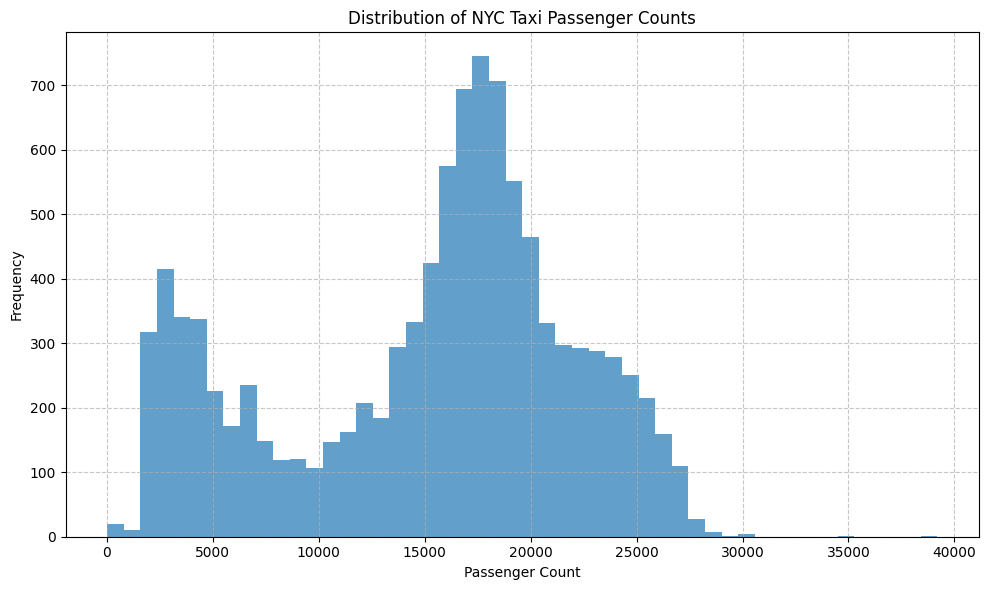

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(nyc_taxi['value'], bins=50, alpha=0.7)
plt.title('Distribution of NYC Taxi Passenger Counts')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This histogram represents the frequency distribution of passenger numbers (value) in the data set, with passenger numbers along the x-axis (0 to 40,000) and frequency along the y-axis (0 to 700). The data is broken down into 50 bins, illustrating how often each range of passenger numbers.
Right skew, peak at 15,000–20,000 passengers , at the 50th percentile . Heavy tail on the high end, with single points above 30,000 , showing potential anomalies like holiday surges. Lower end  shows slack times, perhaps late night or during disruptions.

Visualization and a short description # 2

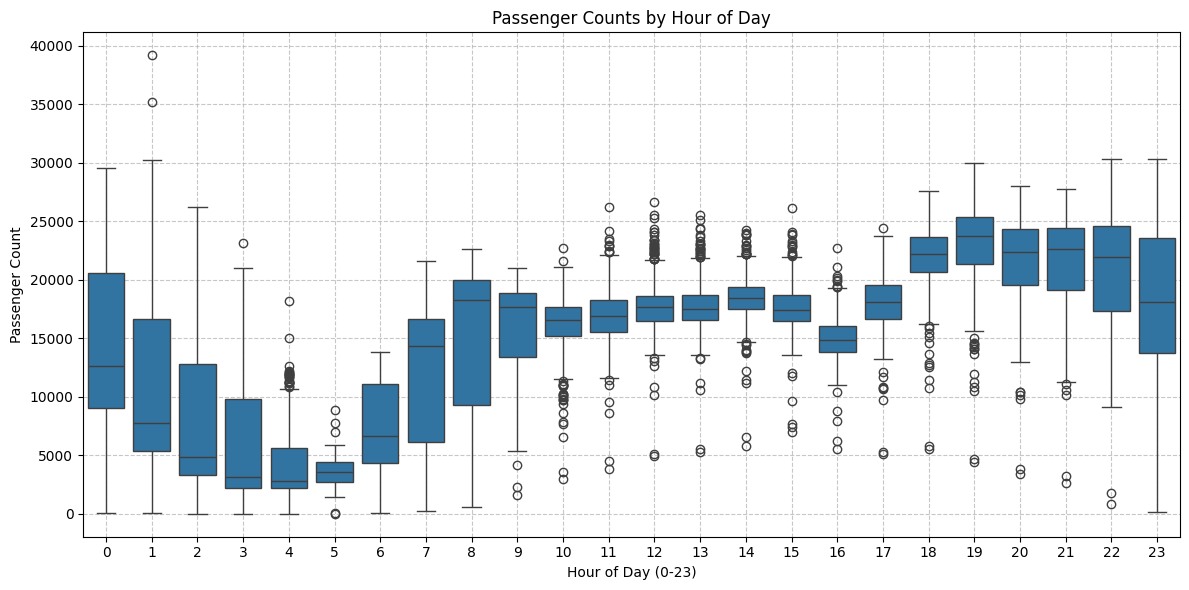

In [ ]:
nyc_taxi['hour'] = nyc_taxi['timestamp'].dt.hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='value', data=nyc_taxi)
plt.title('Passenger Counts by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Passenger Count')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This box plot shows the value of passengers for every hour of the day (0–23), with the x-axis as hours and the y-axis as numbers of passengers (0 to 40,000). Every box is interquartile range , and a line across the median. Passenger numbers vary wildly by the hour—lowest medians are at 3–5 AM and highest at 19–22. Outliers  become more prominent, especially in the late night ranges, with others reaching up to 35,000–40,000, which are event-based peaks. Dispersion is higher during the day, reflecting higher variability.

Visualization and a short description # 3

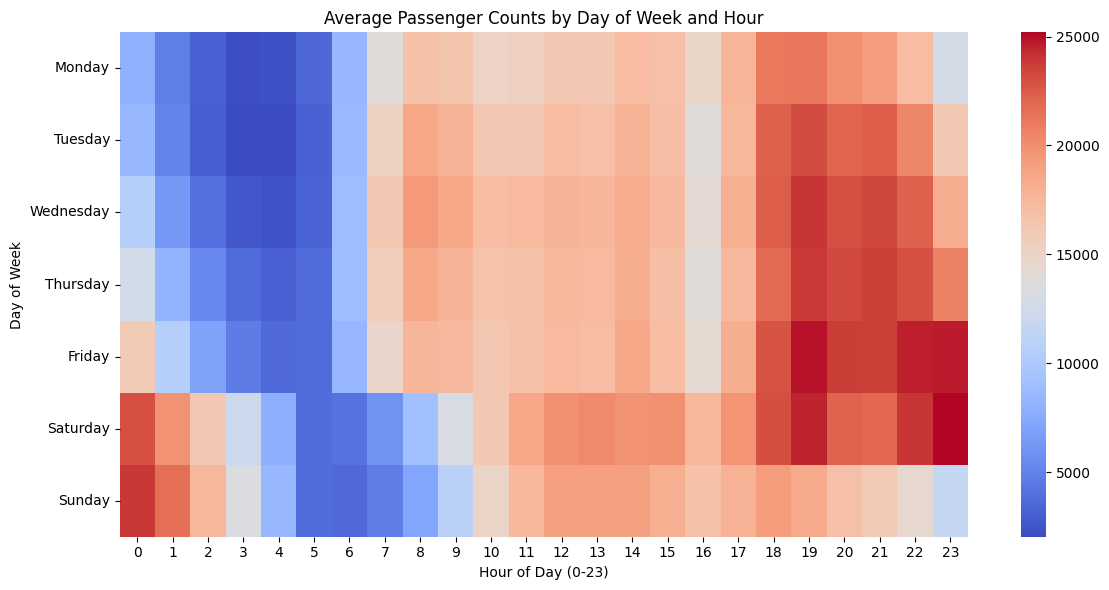

In [ ]:
nyc_taxi['day_of_week'] = nyc_taxi['timestamp'].dt.day_name()
nyc_taxi['hour'] = nyc_taxi['timestamp'].dt.hour
pivot_table = nyc_taxi.pivot_table(values='value', index='day_of_week', columns='hour', aggfunc='mean')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(day_order)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=False, fmt='.0f')
plt.title('Average Passenger Counts by Day of Week and Hour')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

This heatmap plots average number of passengers by days of the week Monday to Sunday, y-axis and hours in a day 0–23, x-axis, color intensity is number, so this one will show the low value as blue, and the high value as red, as wanted. Color bar on the right scales values from ~5,000 (blue) to ~25,000 (red).Red  is seen on weekdays  in evening hours with a peak of around 20,000–25,000, maybe due to nightlife or travel. Blue  is seen in early morning hours  of all days, particularly weekends, when it goes down to ~5,000–7,000. Saturday and Sunday see more numbers late into the night, indicating weekend activity, while weekdays see a trough between 9–12.


4. Identify any missing values (e.g. using pandas.isnull().sum()). Handle any missing values (imputation or removal). Common imputation methods include: forward/backward fill, mean/median imputation, linear interpolation).

In [ ]:
columns_to_drop = ['hour', 'day_of_week']
nyc_taxi = nyc_taxi.drop(columns=[col for col in columns_to_drop if col in nyc_taxi.columns], errors='ignore')
print("\nMissing Values in Each Column:")
print(nyc_taxi.isnull().sum())


Missing Values in Each Column:
timestamp    0
value        0
dtype: int64


5. Preprocess the dataset.

   a. Normalize the data.

In [ ]:
values = nyc_taxi['value'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values)
nyc_taxi['value'] = scaled_values
print("\nNormalized Values in Each Column:")
print(nyc_taxi.head())


Normalized Values in Each Column:
            timestamp     value
0 2014-07-01 00:00:00  0.276506
1 2014-07-01 00:30:00  0.207175
2 2014-07-01 01:00:00  0.158259
3 2014-07-01 01:30:00  0.118605
4 2014-07-01 02:00:00  0.097272


   b. [If needed] Address class imbalance in the target column. Possible solutions: oversampling; undersampling; data augmentation techniques for the minority class; assign higher weights to the minority class and lower weights to the majority class, etc.

   c. [If needed] Convert target variable needs to numerical format. You can use one-hot encoding. However, if you use torch.nn.CrossEntropyLoss for your network, it expects class indices (0, 1, 2) directly, not one-hot encoded vectors. Therefore, ensure your labels are integer tensors (e.g., torch.LongTensor).

6. Split the dataset into training, testing and validation sets. You can use train_test_split from scikit-learn.

In [ ]:
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i:i + window_size])
    return np.array(sequences)

window_size = 48
X = create_sequences(nyc_taxi['value'].values, window_size)
timestamps = nyc_taxi['timestamp'].values[window_size-1:]
X_train, X_temp, timestamps_train, timestamps_temp = train_test_split(
    X, timestamps, test_size=0.3, shuffle=False, random_state=42
)
X_val, X_test, timestamps_val, timestamps_test = train_test_split(
    X_temp, timestamps_temp, test_size=0.5, shuffle=False, random_state=42
)

print("Dataset Split Summary:")
print(f"Training set: {X_train.shape[0]}")
print(f"Validation set: {X_val.shape[0]}")
print(f"Test set: {X_test.shape[0]}")

Dataset Split Summary:
Training set: 7191
Validation set: 1541
Test set: 1541


In [ ]:
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
X_test_tensor = torch.FloatTensor(X_test)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Step 2: Autoencoder model building

1. Choose and implement one of the following: Autoencoder,Variational Autoencoder (VAE) or other version of Autoencoder for anomaly detection.

2. Experiment with different architectures. Build and train 3 different autoencoder architectures for anomaly detection. Consider experimenting with:
   - Different layer types (Dense, LSTM for time series, Conv1D for sequential data)
   - Number of hidden layers and units
   - Activation functions (ReLU, sigmoid)
   - Print model summary using torchinfo.summary

### Model 1 Architecture ###

In [ ]:
class DenseAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_units=8, dropout_rate=0.0):
        super(DenseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, hidden_units)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_units, 16),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, input_size),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
input_size = window_size  # 48
dense_ae = DenseAutoencoder(input_size).to(device)
print("Dense Autoencoder Summary:")
summary(dense_ae, input_size=(1, input_size))

Dense Autoencoder Summary:


Layer (type:depth-idx)                   Output Shape              Param #
DenseAutoencoder                         [1, 48]                   --
├─Sequential: 1-1                        [1, 8]                    --
│    └─Linear: 2-1                       [1, 32]                   1,568
│    └─ReLU: 2-2                         [1, 32]                   --
│    └─Dropout: 2-3                      [1, 32]                   --
│    └─Linear: 2-4                       [1, 16]                   528
│    └─ReLU: 2-5                         [1, 16]                   --
│    └─Dropout: 2-6                      [1, 16]                   --
│    └─Linear: 2-7                       [1, 8]                    136
├─Sequential: 1-2                        [1, 48]                   --
│    └─Linear: 2-8                       [1, 16]                   144
│    └─ReLU: 2-9                         [1, 16]                   --
│    └─Dropout: 2-10                     [1, 16]                   --
│    └─Li

### Model 2 Architecture ###

In [ ]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.0):
        super(LSTMAutoencoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.encoder_lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.decoder_lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, input_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = x.unsqueeze(-1)
        _, (hidden, _) = self.encoder_lstm(x)
        hidden = hidden[-1].unsqueeze(1).repeat(1, x.size(1), 1)
        decoded, _ = self.decoder_lstm(hidden)
        decoded = self.fc(decoded)
        return self.sigmoid(decoded).squeeze(-1)

# Initialize model
lstm_ae = LSTMAutoencoder(input_size=1, hidden_size=16, num_layers=2).to(device)
print("LSTM Autoencoder Summary:")
summary(lstm_ae, input_size=(1, window_size))  # Input as (batch, seq_len)

LSTM Autoencoder Summary:


Layer (type:depth-idx)                   Output Shape              Param #
LSTMAutoencoder                          [1, 48]                   --
├─LSTM: 1-1                              [1, 48, 16]               3,392
├─LSTM: 1-2                              [1, 48, 16]               4,352
├─Linear: 1-3                            [1, 48, 1]                17
├─Sigmoid: 1-4                           [1, 48, 1]                --
Total params: 7,761
Trainable params: 7,761
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.37
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04

### Model 3 Architecture ###

In [ ]:
class Conv1DAutoencoder(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(Conv1DAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool1d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.ConvTranspose1d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.unsqueeze(1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.squeeze(1)


conv1d_ae = Conv1DAutoencoder().to(device)
print("Conv1D Autoencoder Summary:")
summary(conv1d_ae, input_size=(1, window_size))

Conv1D Autoencoder Summary:


Layer (type:depth-idx)                   Output Shape              Param #
Conv1DAutoencoder                        [1, 48]                   --
├─Sequential: 1-1                        [1, 8, 12]                --
│    └─Conv1d: 2-1                       [1, 16, 48]               64
│    └─ReLU: 2-2                         [1, 16, 48]               --
│    └─Dropout: 2-3                      [1, 16, 48]               --
│    └─MaxPool1d: 2-4                    [1, 16, 24]               --
│    └─Conv1d: 2-5                       [1, 8, 24]                392
│    └─ReLU: 2-6                         [1, 8, 24]                --
│    └─Dropout: 2-7                      [1, 8, 24]                --
│    └─MaxPool1d: 2-8                    [1, 8, 12]                --
├─Sequential: 1-2                        [1, 1, 48]                --
│    └─ConvTranspose1d: 2-9              [1, 16, 24]               528
│    └─ReLU: 2-10                        [1, 16, 24]               --
│    └─Dropou

3. Model training and hyperparameter tuning:
   - Choose an appropriate loss function and optimizer (e.g., Adam).
   - Train your model and monitor its performance on the training and validation sets.
   - Tune hyperparameters (learning rate, batch size, number of epochs, hidden units, dropout rate) using the validation set.
   - Plot the training and validation loss and accuracy curves over epochs. Analyze the plots for signs of overfitting or underfitting. Adjust your model or hyperparameters if needed.


Tuning Dense AE

Testing Dense AE with config: {'lr': 0.1, 'batch_size': 64, 'epochs': 10, 'hidden_units': 16, 'dropout_rate': 0.3}
Dense AE | Epoch 1/10, Train Loss: 0.031642, Val Loss: 0.030507
Dense AE | Epoch 2/10, Train Loss: 0.031153, Val Loss: 0.030520
Dense AE | Epoch 3/10, Train Loss: 0.031152, Val Loss: 0.030524
Dense AE | Epoch 4/10, Train Loss: 0.031152, Val Loss: 0.030526
Dense AE | Epoch 5/10, Train Loss: 0.031152, Val Loss: 0.030527
Dense AE | Epoch 6/10, Train Loss: 0.031152, Val Loss: 0.030527
Dense AE | Epoch 7/10, Train Loss: 0.031152, Val Loss: 0.030528
Dense AE | Epoch 8/10, Train Loss: 0.031152, Val Loss: 0.030528
Dense AE | Epoch 9/10, Train Loss: 0.031152, Val Loss: 0.030528
Dense AE | Epoch 10/10, Train Loss: 0.031152, Val Loss: 0.030529


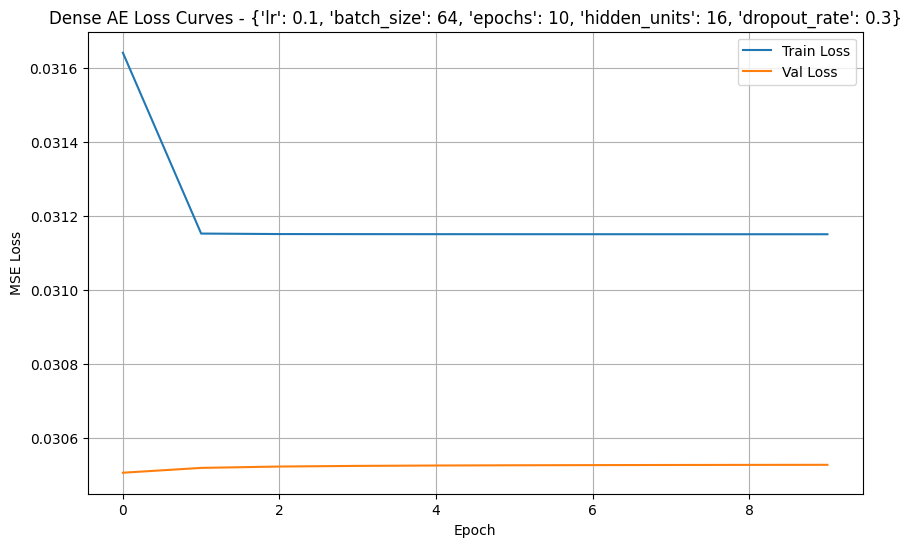


Testing Dense AE with config: {'lr': 0.1, 'batch_size': 128, 'epochs': 10, 'hidden_units': 16, 'dropout_rate': 0.1}
Dense AE | Epoch 1/10, Train Loss: 0.033034, Val Loss: 0.030794
Dense AE | Epoch 2/10, Train Loss: 0.031040, Val Loss: 0.030543
Dense AE | Epoch 3/10, Train Loss: 0.031131, Val Loss: 0.030517
Dense AE | Epoch 4/10, Train Loss: 0.031148, Val Loss: 0.030511
Dense AE | Epoch 5/10, Train Loss: 0.031155, Val Loss: 0.030508
Dense AE | Epoch 6/10, Train Loss: 0.031159, Val Loss: 0.030507
Dense AE | Epoch 7/10, Train Loss: 0.031162, Val Loss: 0.030506
Dense AE | Epoch 8/10, Train Loss: 0.031164, Val Loss: 0.030506
Dense AE | Epoch 9/10, Train Loss: 0.031165, Val Loss: 0.030505
Dense AE | Epoch 10/10, Train Loss: 0.031167, Val Loss: 0.030505


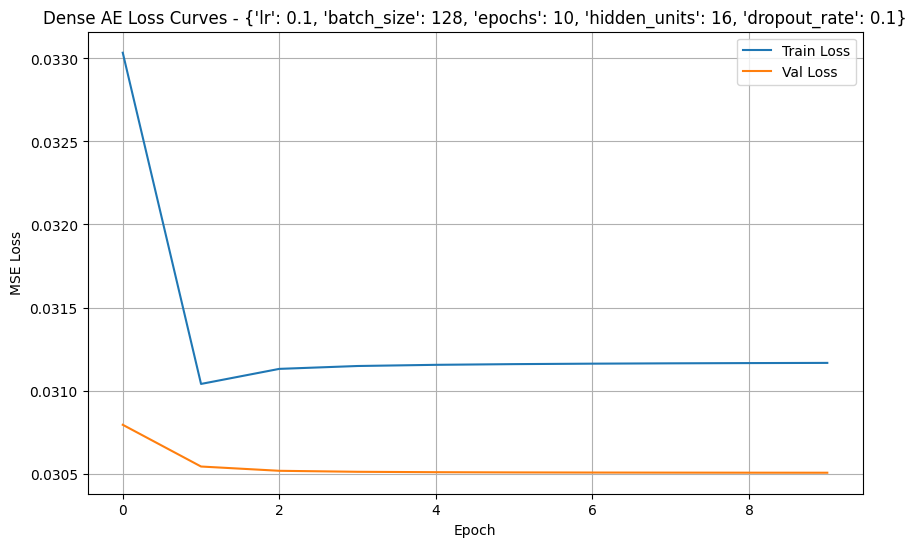


Testing Dense AE with config: {'lr': 0.001, 'batch_size': 128, 'epochs': 50, 'hidden_units': 24, 'dropout_rate': 0.1}
Dense AE | Epoch 1/50, Train Loss: 0.038067, Val Loss: 0.033500
Dense AE | Epoch 2/50, Train Loss: 0.031974, Val Loss: 0.032825
Dense AE | Epoch 3/50, Train Loss: 0.031415, Val Loss: 0.031945
Dense AE | Epoch 4/50, Train Loss: 0.029566, Val Loss: 0.026181
Dense AE | Epoch 5/50, Train Loss: 0.024159, Val Loss: 0.022731
Dense AE | Epoch 6/50, Train Loss: 0.022491, Val Loss: 0.021275
Dense AE | Epoch 7/50, Train Loss: 0.021072, Val Loss: 0.020010
Dense AE | Epoch 8/50, Train Loss: 0.019690, Val Loss: 0.017589
Dense AE | Epoch 9/50, Train Loss: 0.016448, Val Loss: 0.014289
Dense AE | Epoch 10/50, Train Loss: 0.014128, Val Loss: 0.012750
Dense AE | Epoch 11/50, Train Loss: 0.012523, Val Loss: 0.011207
Dense AE | Epoch 12/50, Train Loss: 0.010981, Val Loss: 0.010149
Dense AE | Epoch 13/50, Train Loss: 0.010252, Val Loss: 0.009789
Dense AE | Epoch 14/50, Train Loss: 0.009785,

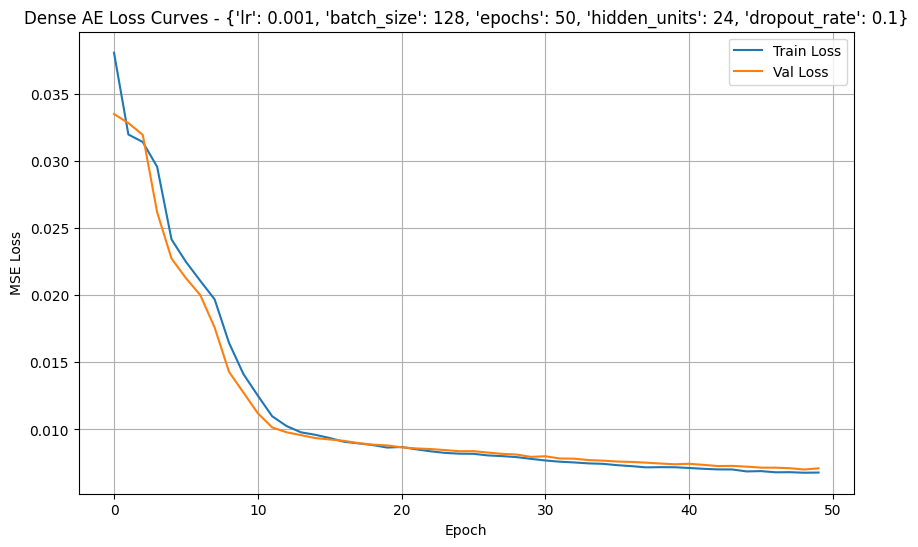


Testing Dense AE with config: {'lr': 0.1, 'batch_size': 128, 'epochs': 50, 'hidden_units': 8, 'dropout_rate': 0.1}
Dense AE | Epoch 1/50, Train Loss: 0.179518, Val Loss: 0.169513
Dense AE | Epoch 2/50, Train Loss: 0.183203, Val Loss: 0.169513
Dense AE | Epoch 3/50, Train Loss: 0.183203, Val Loss: 0.169513
Dense AE | Epoch 4/50, Train Loss: 0.183203, Val Loss: 0.169513
Dense AE | Epoch 5/50, Train Loss: 0.183203, Val Loss: 0.169513
Dense AE | Epoch 6/50, Train Loss: 0.183203, Val Loss: 0.169513
Dense AE | Epoch 7/50, Train Loss: 0.183203, Val Loss: 0.169513
Dense AE | Epoch 8/50, Train Loss: 0.183203, Val Loss: 0.169513
Dense AE | Epoch 9/50, Train Loss: 0.183203, Val Loss: 0.169513
Dense AE | Epoch 10/50, Train Loss: 0.183203, Val Loss: 0.169513
Dense AE | Epoch 11/50, Train Loss: 0.183203, Val Loss: 0.169513
Dense AE | Epoch 12/50, Train Loss: 0.183203, Val Loss: 0.169513
Dense AE | Epoch 13/50, Train Loss: 0.183202, Val Loss: 0.169513
Dense AE | Epoch 14/50, Train Loss: 0.183203, Va

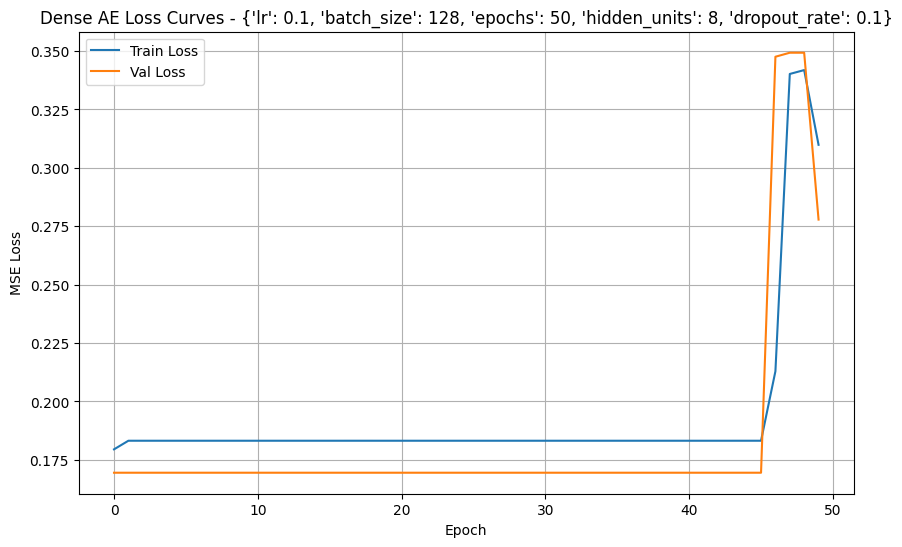


Testing Dense AE with config: {'lr': 0.1, 'batch_size': 128, 'epochs': 25, 'hidden_units': 24, 'dropout_rate': 0.1}
Dense AE | Epoch 1/25, Train Loss: 0.031562, Val Loss: 0.030577
Dense AE | Epoch 2/25, Train Loss: 0.031112, Val Loss: 0.030499
Dense AE | Epoch 3/25, Train Loss: 0.031158, Val Loss: 0.030496
Dense AE | Epoch 4/25, Train Loss: 0.031164, Val Loss: 0.030498
Dense AE | Epoch 5/25, Train Loss: 0.031166, Val Loss: 0.030499
Dense AE | Epoch 6/25, Train Loss: 0.031168, Val Loss: 0.030500
Dense AE | Epoch 7/25, Train Loss: 0.031169, Val Loss: 0.030500
Dense AE | Epoch 8/25, Train Loss: 0.031170, Val Loss: 0.030501
Dense AE | Epoch 9/25, Train Loss: 0.031170, Val Loss: 0.030501
Dense AE | Epoch 10/25, Train Loss: 0.031171, Val Loss: 0.030502
Dense AE | Epoch 11/25, Train Loss: 0.031171, Val Loss: 0.030502
Dense AE | Epoch 12/25, Train Loss: 0.031171, Val Loss: 0.030502
Dense AE | Epoch 13/25, Train Loss: 0.031171, Val Loss: 0.030502
Dense AE | Epoch 14/25, Train Loss: 0.031172, V

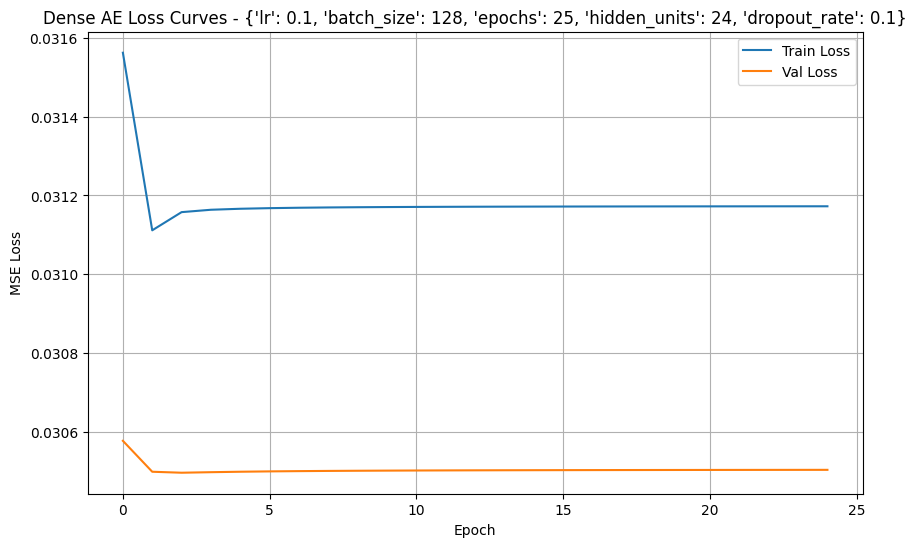


Testing Dense AE with config: {'lr': 0.001, 'batch_size': 128, 'epochs': 10, 'hidden_units': 16, 'dropout_rate': 0.1}
Dense AE | Epoch 1/10, Train Loss: 0.039375, Val Loss: 0.033420
Dense AE | Epoch 2/10, Train Loss: 0.031727, Val Loss: 0.031561
Dense AE | Epoch 3/10, Train Loss: 0.027831, Val Loss: 0.022819
Dense AE | Epoch 4/10, Train Loss: 0.020732, Val Loss: 0.016548
Dense AE | Epoch 5/10, Train Loss: 0.015835, Val Loss: 0.013164
Dense AE | Epoch 6/10, Train Loss: 0.012887, Val Loss: 0.011460
Dense AE | Epoch 7/10, Train Loss: 0.011479, Val Loss: 0.010629
Dense AE | Epoch 8/10, Train Loss: 0.010755, Val Loss: 0.010350
Dense AE | Epoch 9/10, Train Loss: 0.010214, Val Loss: 0.009997
Dense AE | Epoch 10/10, Train Loss: 0.009907, Val Loss: 0.009752


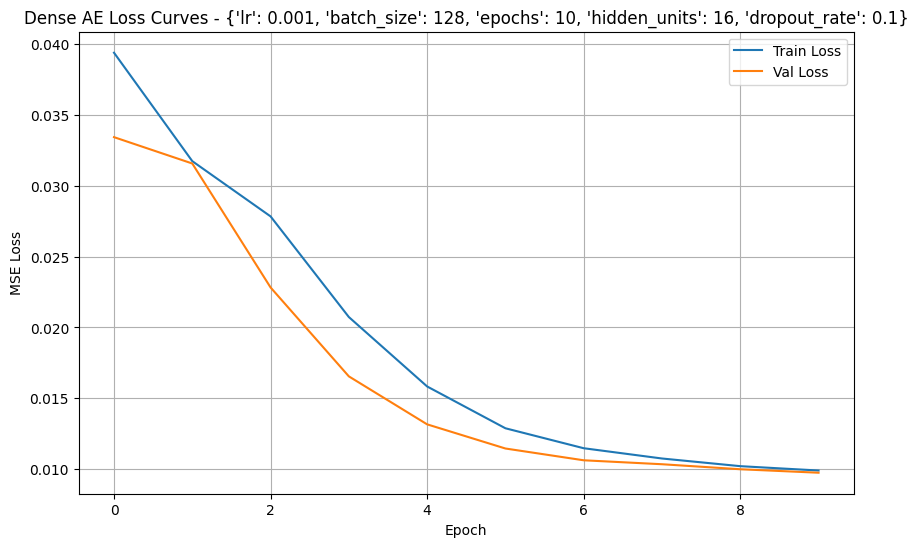


Testing Dense AE with config: {'lr': 0.01, 'batch_size': 64, 'epochs': 25, 'hidden_units': 24, 'dropout_rate': 0.2}
Dense AE | Epoch 1/25, Train Loss: 0.028478, Val Loss: 0.023098
Dense AE | Epoch 2/25, Train Loss: 0.024250, Val Loss: 0.021865
Dense AE | Epoch 3/25, Train Loss: 0.023219, Val Loss: 0.021180
Dense AE | Epoch 4/25, Train Loss: 0.022717, Val Loss: 0.021251
Dense AE | Epoch 5/25, Train Loss: 0.022189, Val Loss: 0.021591
Dense AE | Epoch 6/25, Train Loss: 0.021462, Val Loss: 0.022153
Dense AE | Epoch 7/25, Train Loss: 0.021384, Val Loss: 0.021751
Dense AE | Epoch 8/25, Train Loss: 0.021200, Val Loss: 0.021965
Dense AE | Epoch 9/25, Train Loss: 0.020826, Val Loss: 0.022056
Dense AE | Epoch 10/25, Train Loss: 0.020975, Val Loss: 0.021029
Dense AE | Epoch 11/25, Train Loss: 0.019744, Val Loss: 0.018375
Dense AE | Epoch 12/25, Train Loss: 0.018400, Val Loss: 0.017731
Dense AE | Epoch 13/25, Train Loss: 0.018536, Val Loss: 0.018073
Dense AE | Epoch 14/25, Train Loss: 0.018172, V

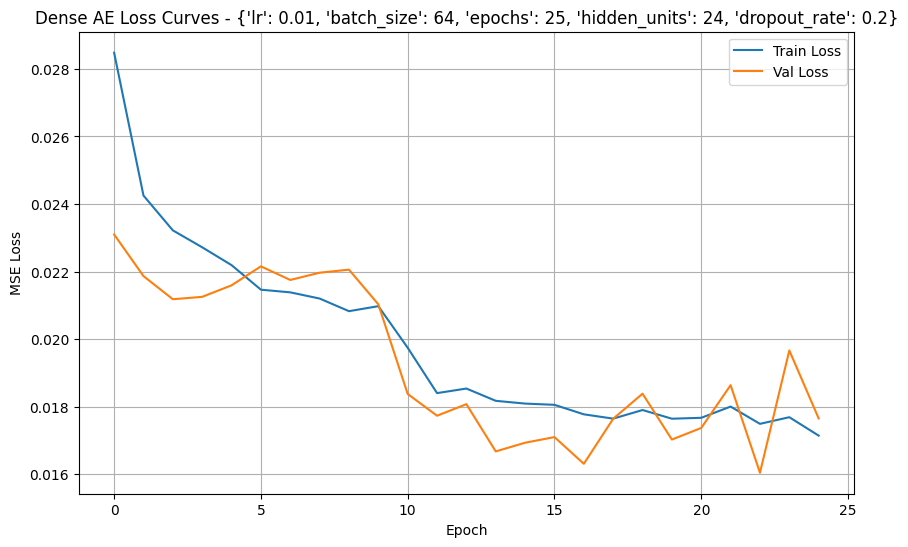


Testing Dense AE with config: {'lr': 0.1, 'batch_size': 128, 'epochs': 50, 'hidden_units': 8, 'dropout_rate': 0.1}
Dense AE | Epoch 1/50, Train Loss: 0.068136, Val Loss: 0.030727
Dense AE | Epoch 2/50, Train Loss: 0.031100, Val Loss: 0.030569
Dense AE | Epoch 3/50, Train Loss: 0.031120, Val Loss: 0.030535
Dense AE | Epoch 4/50, Train Loss: 0.031139, Val Loss: 0.030522
Dense AE | Epoch 5/50, Train Loss: 0.031148, Val Loss: 0.030516
Dense AE | Epoch 6/50, Train Loss: 0.031154, Val Loss: 0.030513
Dense AE | Epoch 7/50, Train Loss: 0.031158, Val Loss: 0.030511
Dense AE | Epoch 8/50, Train Loss: 0.031161, Val Loss: 0.030510
Dense AE | Epoch 9/50, Train Loss: 0.031163, Val Loss: 0.030509
Dense AE | Epoch 10/50, Train Loss: 0.031164, Val Loss: 0.030508
Dense AE | Epoch 11/50, Train Loss: 0.031165, Val Loss: 0.030507
Dense AE | Epoch 12/50, Train Loss: 0.031166, Val Loss: 0.030507
Dense AE | Epoch 13/50, Train Loss: 0.031167, Val Loss: 0.030507
Dense AE | Epoch 14/50, Train Loss: 0.031168, Va

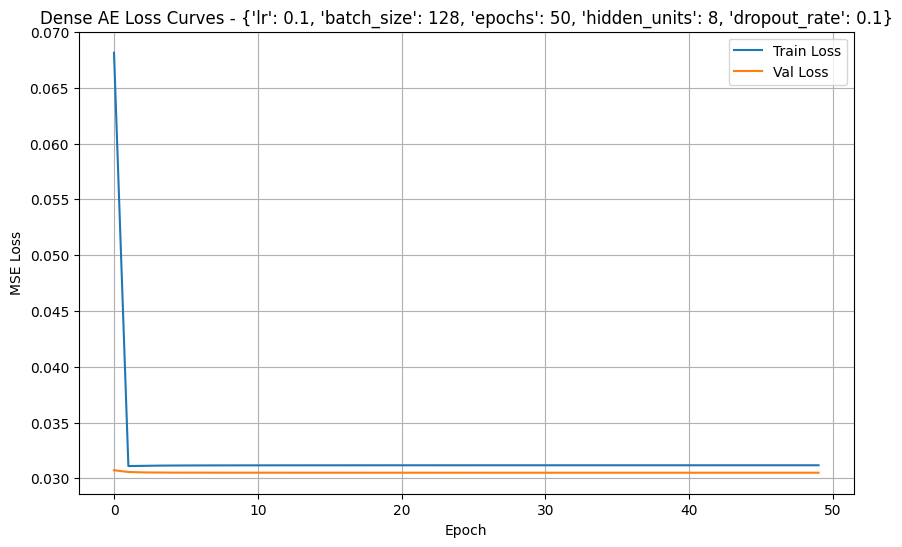


Testing Dense AE with config: {'lr': 0.1, 'batch_size': 128, 'epochs': 50, 'hidden_units': 8, 'dropout_rate': 0.3}
Dense AE | Epoch 1/50, Train Loss: 0.031551, Val Loss: 0.030558
Dense AE | Epoch 2/50, Train Loss: 0.031164, Val Loss: 0.030482
Dense AE | Epoch 3/50, Train Loss: 0.031166, Val Loss: 0.030488
Dense AE | Epoch 4/50, Train Loss: 0.031168, Val Loss: 0.030492
Dense AE | Epoch 5/50, Train Loss: 0.031170, Val Loss: 0.030495
Dense AE | Epoch 6/50, Train Loss: 0.031170, Val Loss: 0.030497
Dense AE | Epoch 7/50, Train Loss: 0.031171, Val Loss: 0.030498
Dense AE | Epoch 8/50, Train Loss: 0.031171, Val Loss: 0.030499
Dense AE | Epoch 9/50, Train Loss: 0.031172, Val Loss: 0.030500
Dense AE | Epoch 10/50, Train Loss: 0.031172, Val Loss: 0.030500
Dense AE | Epoch 11/50, Train Loss: 0.031172, Val Loss: 0.030501
Dense AE | Epoch 12/50, Train Loss: 0.031172, Val Loss: 0.030501
Dense AE | Epoch 13/50, Train Loss: 0.031172, Val Loss: 0.030501
Dense AE | Epoch 14/50, Train Loss: 0.031172, Va

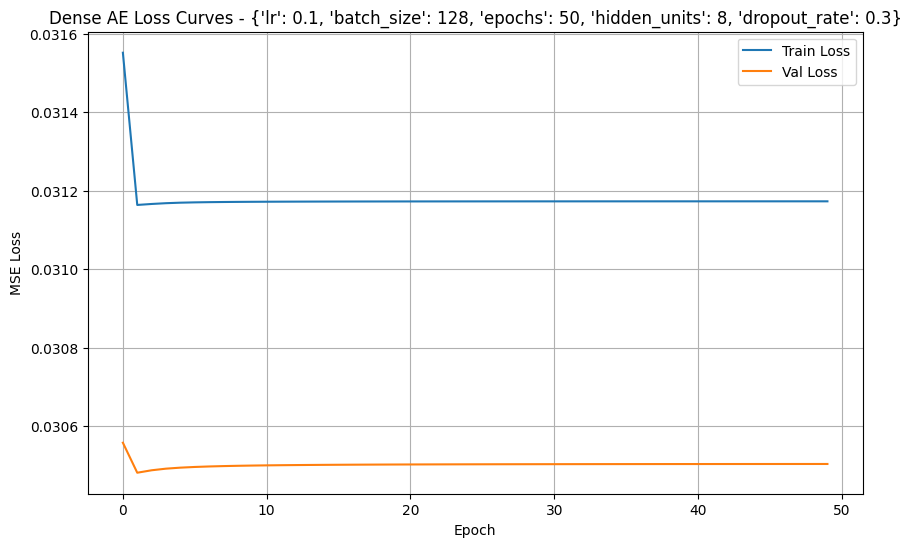


Testing Dense AE with config: {'lr': 0.01, 'batch_size': 64, 'epochs': 25, 'hidden_units': 24, 'dropout_rate': 0.1}
Dense AE | Epoch 1/25, Train Loss: 0.031801, Val Loss: 0.030929
Dense AE | Epoch 2/25, Train Loss: 0.031028, Val Loss: 0.031110
Dense AE | Epoch 3/25, Train Loss: 0.030954, Val Loss: 0.031204
Dense AE | Epoch 4/25, Train Loss: 0.030896, Val Loss: 0.031291
Dense AE | Epoch 5/25, Train Loss: 0.030839, Val Loss: 0.031382
Dense AE | Epoch 6/25, Train Loss: 0.030013, Val Loss: 0.025240
Dense AE | Epoch 7/25, Train Loss: 0.024853, Val Loss: 0.021674
Dense AE | Epoch 8/25, Train Loss: 0.021531, Val Loss: 0.020141
Dense AE | Epoch 9/25, Train Loss: 0.020893, Val Loss: 0.019777
Dense AE | Epoch 10/25, Train Loss: 0.020057, Val Loss: 0.017211
Dense AE | Epoch 11/25, Train Loss: 0.017841, Val Loss: 0.017068
Dense AE | Epoch 12/25, Train Loss: 0.017088, Val Loss: 0.015278
Dense AE | Epoch 13/25, Train Loss: 0.016528, Val Loss: 0.014723
Dense AE | Epoch 14/25, Train Loss: 0.016109, V

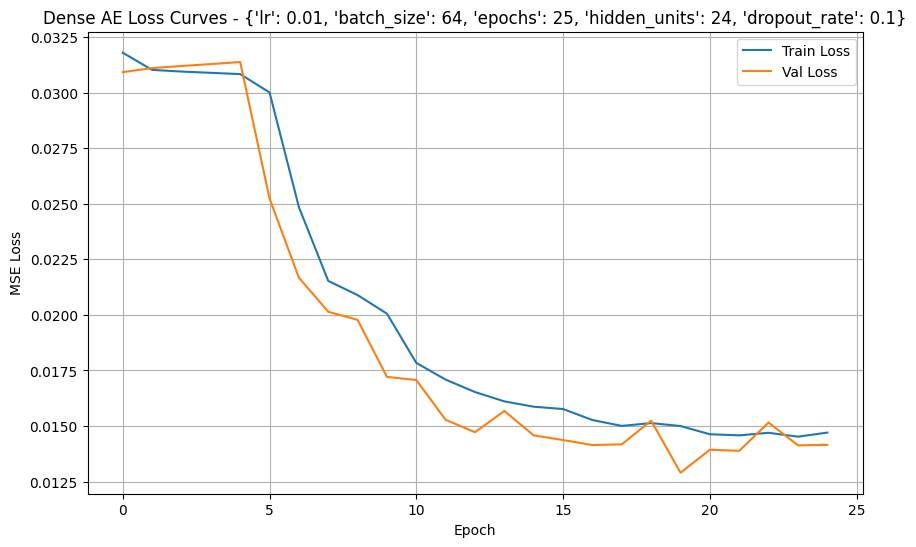


Tuning LSTM AE

Testing LSTM AE with config: {'lr': 0.001, 'batch_size': 64, 'epochs': 25, 'hidden_units': 24, 'dropout_rate': 0.2}
LSTM AE | Epoch 1/25, Train Loss: 0.034004, Val Loss: 0.031507
LSTM AE | Epoch 2/25, Train Loss: 0.031052, Val Loss: 0.031567
LSTM AE | Epoch 3/25, Train Loss: 0.030926, Val Loss: 0.031573
LSTM AE | Epoch 4/25, Train Loss: 0.030869, Val Loss: 0.031559
LSTM AE | Epoch 5/25, Train Loss: 0.030836, Val Loss: 0.031546
LSTM AE | Epoch 6/25, Train Loss: 0.030818, Val Loss: 0.031531
LSTM AE | Epoch 7/25, Train Loss: 0.030804, Val Loss: 0.031511
LSTM AE | Epoch 8/25, Train Loss: 0.030794, Val Loss: 0.031493
LSTM AE | Epoch 9/25, Train Loss: 0.030788, Val Loss: 0.031472
LSTM AE | Epoch 10/25, Train Loss: 0.030781, Val Loss: 0.031454
LSTM AE | Epoch 11/25, Train Loss: 0.030776, Val Loss: 0.031437
LSTM AE | Epoch 12/25, Train Loss: 0.030774, Val Loss: 0.031422
LSTM AE | Epoch 13/25, Train Loss: 0.030770, Val Loss: 0.031406
LSTM AE | Epoch 14/25, Train Loss: 0.030766,

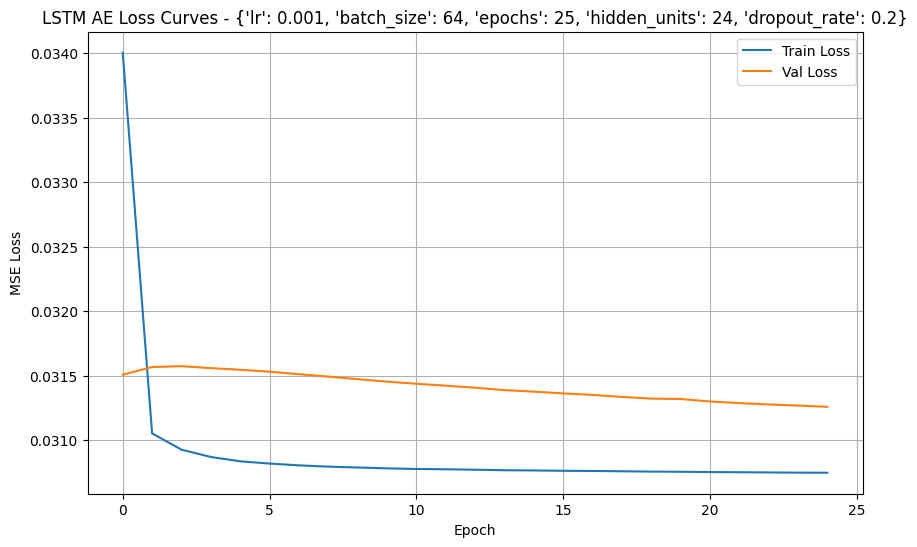


Testing LSTM AE with config: {'lr': 0.001, 'batch_size': 32, 'epochs': 50, 'hidden_units': 24, 'dropout_rate': 0.2}
LSTM AE | Epoch 1/50, Train Loss: 0.033299, Val Loss: 0.031094
LSTM AE | Epoch 2/50, Train Loss: 0.030932, Val Loss: 0.031110
LSTM AE | Epoch 3/50, Train Loss: 0.030847, Val Loss: 0.031161
LSTM AE | Epoch 4/50, Train Loss: 0.030803, Val Loss: 0.031193
LSTM AE | Epoch 5/50, Train Loss: 0.030781, Val Loss: 0.031219
LSTM AE | Epoch 6/50, Train Loss: 0.030766, Val Loss: 0.031237
LSTM AE | Epoch 7/50, Train Loss: 0.030753, Val Loss: 0.031255
LSTM AE | Epoch 8/50, Train Loss: 0.030745, Val Loss: 0.031271
LSTM AE | Epoch 9/50, Train Loss: 0.030738, Val Loss: 0.031281
LSTM AE | Epoch 10/50, Train Loss: 0.030735, Val Loss: 0.031294
LSTM AE | Epoch 11/50, Train Loss: 0.030730, Val Loss: 0.031305
LSTM AE | Epoch 12/50, Train Loss: 0.030727, Val Loss: 0.031313
LSTM AE | Epoch 13/50, Train Loss: 0.030723, Val Loss: 0.031322
LSTM AE | Epoch 14/50, Train Loss: 0.030721, Val Loss: 0.031

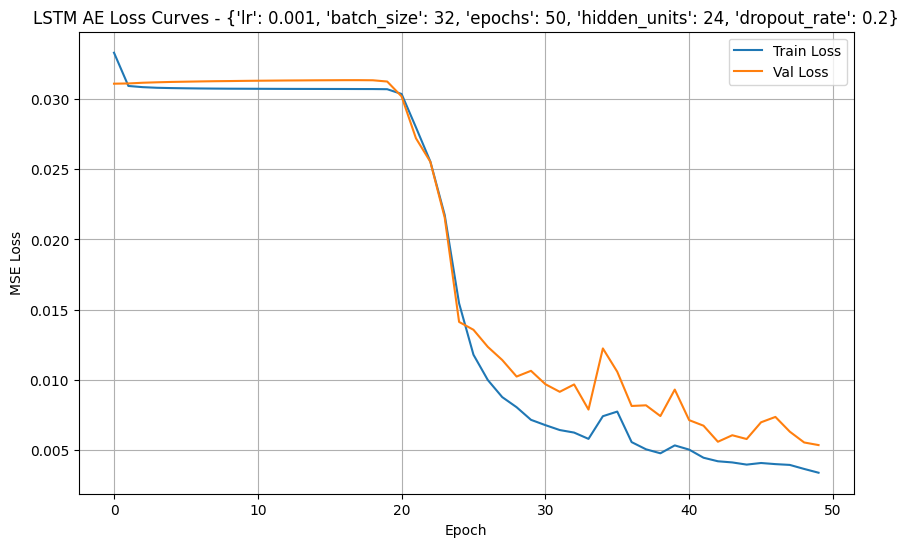


Testing LSTM AE with config: {'lr': 0.01, 'batch_size': 64, 'epochs': 25, 'hidden_units': 8, 'dropout_rate': 0.1}
LSTM AE | Epoch 1/25, Train Loss: 0.030833, Val Loss: 0.031355
LSTM AE | Epoch 2/25, Train Loss: 0.030768, Val Loss: 0.031440
LSTM AE | Epoch 3/25, Train Loss: 0.030754, Val Loss: 0.031445
LSTM AE | Epoch 4/25, Train Loss: 0.030749, Val Loss: 0.031441
LSTM AE | Epoch 5/25, Train Loss: 0.030746, Val Loss: 0.031428
LSTM AE | Epoch 6/25, Train Loss: 0.030748, Val Loss: 0.031491
LSTM AE | Epoch 7/25, Train Loss: 0.030752, Val Loss: 0.031482
LSTM AE | Epoch 8/25, Train Loss: 0.030751, Val Loss: 0.031479
LSTM AE | Epoch 9/25, Train Loss: 0.030750, Val Loss: 0.031493
LSTM AE | Epoch 10/25, Train Loss: 0.030753, Val Loss: 0.031491
LSTM AE | Epoch 11/25, Train Loss: 0.030753, Val Loss: 0.031490
LSTM AE | Epoch 12/25, Train Loss: 0.030753, Val Loss: 0.031490
LSTM AE | Epoch 13/25, Train Loss: 0.030753, Val Loss: 0.031490
LSTM AE | Epoch 14/25, Train Loss: 0.030753, Val Loss: 0.03148

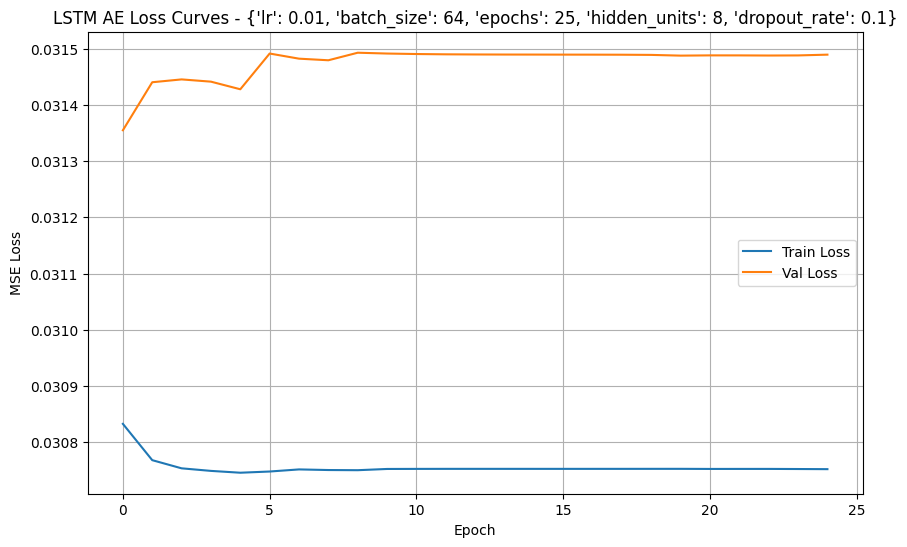


Testing LSTM AE with config: {'lr': 0.001, 'batch_size': 32, 'epochs': 10, 'hidden_units': 16, 'dropout_rate': 0.1}
LSTM AE | Epoch 1/10, Train Loss: 0.032700, Val Loss: 0.031341
LSTM AE | Epoch 2/10, Train Loss: 0.031112, Val Loss: 0.031323
LSTM AE | Epoch 3/10, Train Loss: 0.030993, Val Loss: 0.031329
LSTM AE | Epoch 4/10, Train Loss: 0.030918, Val Loss: 0.031325
LSTM AE | Epoch 5/10, Train Loss: 0.030864, Val Loss: 0.031301
LSTM AE | Epoch 6/10, Train Loss: 0.030810, Val Loss: 0.031169
LSTM AE | Epoch 7/10, Train Loss: 0.030712, Val Loss: 0.030749
LSTM AE | Epoch 8/10, Train Loss: 0.030556, Val Loss: 0.030052
LSTM AE | Epoch 9/10, Train Loss: 0.030560, Val Loss: 0.029680
LSTM AE | Epoch 10/10, Train Loss: 0.029465, Val Loss: 0.029121


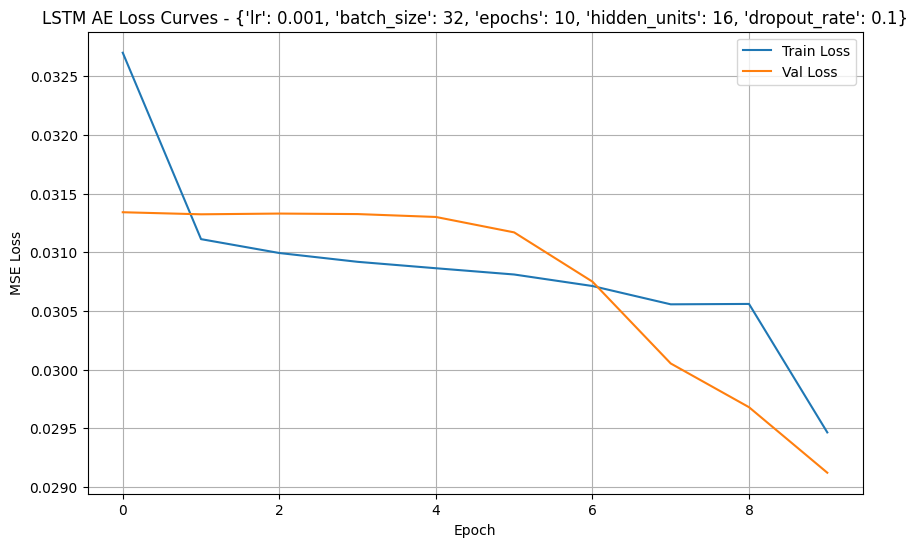


Testing LSTM AE with config: {'lr': 0.001, 'batch_size': 128, 'epochs': 50, 'hidden_units': 24, 'dropout_rate': 0.2}
LSTM AE | Epoch 1/50, Train Loss: 0.034569, Val Loss: 0.032248
LSTM AE | Epoch 2/50, Train Loss: 0.031186, Val Loss: 0.032065
LSTM AE | Epoch 3/50, Train Loss: 0.031133, Val Loss: 0.031916
LSTM AE | Epoch 4/50, Train Loss: 0.031090, Val Loss: 0.031753
LSTM AE | Epoch 5/50, Train Loss: 0.031045, Val Loss: 0.031611
LSTM AE | Epoch 6/50, Train Loss: 0.031008, Val Loss: 0.031494
LSTM AE | Epoch 7/50, Train Loss: 0.030968, Val Loss: 0.031401
LSTM AE | Epoch 8/50, Train Loss: 0.030945, Val Loss: 0.031329
LSTM AE | Epoch 9/50, Train Loss: 0.030921, Val Loss: 0.031268
LSTM AE | Epoch 10/50, Train Loss: 0.030903, Val Loss: 0.031216
LSTM AE | Epoch 11/50, Train Loss: 0.030881, Val Loss: 0.031170
LSTM AE | Epoch 12/50, Train Loss: 0.030865, Val Loss: 0.031132
LSTM AE | Epoch 13/50, Train Loss: 0.030847, Val Loss: 0.031097
LSTM AE | Epoch 14/50, Train Loss: 0.030837, Val Loss: 0.03

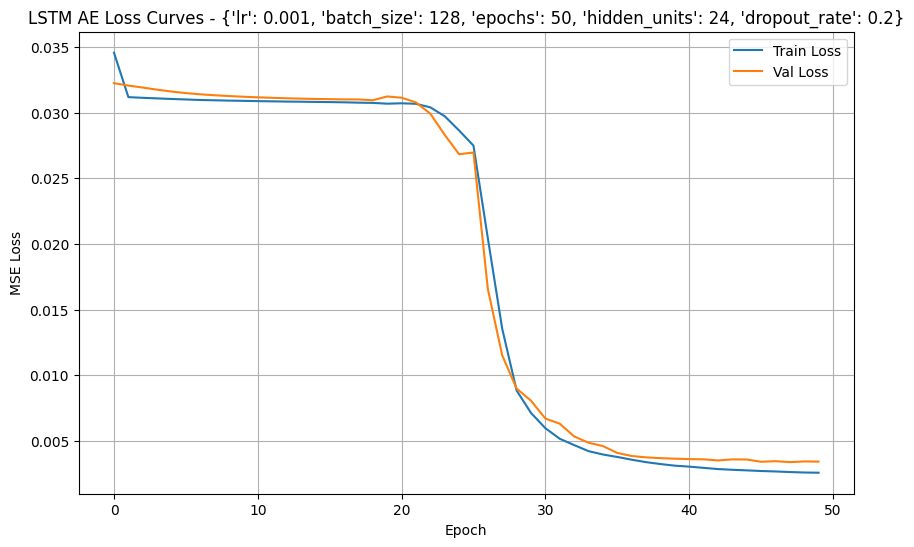


Testing LSTM AE with config: {'lr': 0.1, 'batch_size': 64, 'epochs': 10, 'hidden_units': 16, 'dropout_rate': 0.3}
LSTM AE | Epoch 1/10, Train Loss: 0.031455, Val Loss: 0.030537
LSTM AE | Epoch 2/10, Train Loss: 0.031157, Val Loss: 0.030547
LSTM AE | Epoch 3/10, Train Loss: 0.031163, Val Loss: 0.030548
LSTM AE | Epoch 4/10, Train Loss: 0.031164, Val Loss: 0.030548
LSTM AE | Epoch 5/10, Train Loss: 0.031164, Val Loss: 0.030548
LSTM AE | Epoch 6/10, Train Loss: 0.031164, Val Loss: 0.030548
LSTM AE | Epoch 7/10, Train Loss: 0.031164, Val Loss: 0.030548
LSTM AE | Epoch 8/10, Train Loss: 0.031165, Val Loss: 0.030548
LSTM AE | Epoch 9/10, Train Loss: 0.031165, Val Loss: 0.030548
LSTM AE | Epoch 10/10, Train Loss: 0.031165, Val Loss: 0.030548


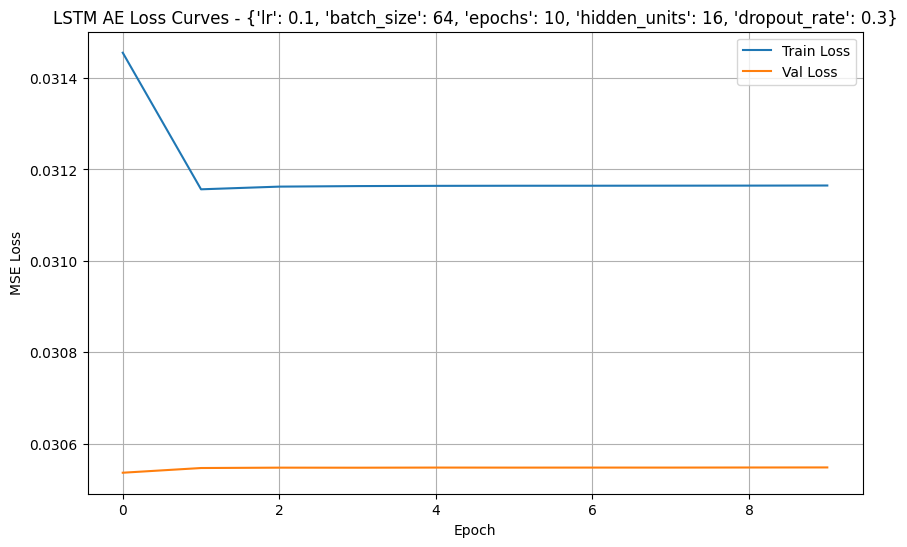


Testing LSTM AE with config: {'lr': 0.001, 'batch_size': 32, 'epochs': 10, 'hidden_units': 16, 'dropout_rate': 0.2}
LSTM AE | Epoch 1/10, Train Loss: 0.031591, Val Loss: 0.031340
LSTM AE | Epoch 2/10, Train Loss: 0.030905, Val Loss: 0.031411
LSTM AE | Epoch 3/10, Train Loss: 0.030844, Val Loss: 0.031438
LSTM AE | Epoch 4/10, Train Loss: 0.030807, Val Loss: 0.031440
LSTM AE | Epoch 5/10, Train Loss: 0.030783, Val Loss: 0.031439
LSTM AE | Epoch 6/10, Train Loss: 0.030766, Val Loss: 0.031438
LSTM AE | Epoch 7/10, Train Loss: 0.030757, Val Loss: 0.031433
LSTM AE | Epoch 8/10, Train Loss: 0.030746, Val Loss: 0.031425
LSTM AE | Epoch 9/10, Train Loss: 0.030736, Val Loss: 0.031386
LSTM AE | Epoch 10/10, Train Loss: 0.030717, Val Loss: 0.031268


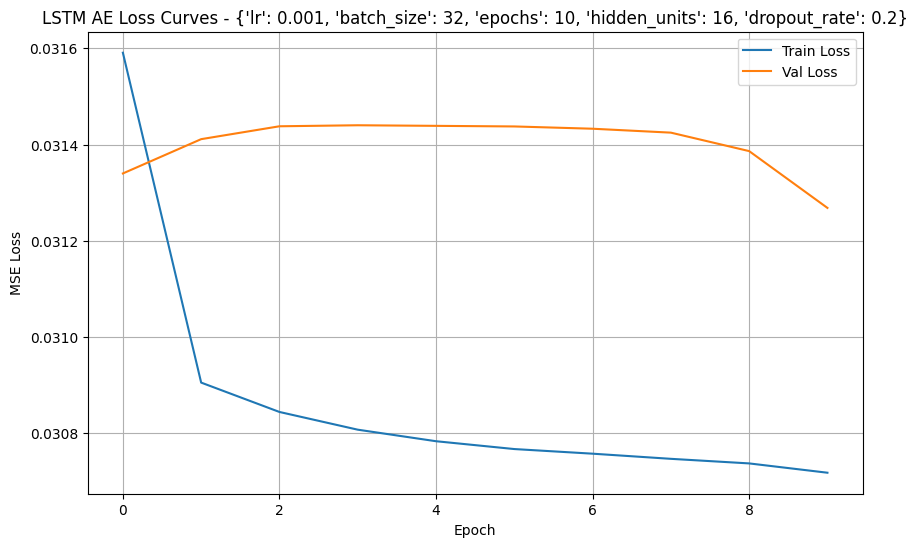


Testing LSTM AE with config: {'lr': 0.001, 'batch_size': 64, 'epochs': 25, 'hidden_units': 24, 'dropout_rate': 0.1}
LSTM AE | Epoch 1/25, Train Loss: 0.036234, Val Loss: 0.031466
LSTM AE | Epoch 2/25, Train Loss: 0.031210, Val Loss: 0.031318
LSTM AE | Epoch 3/25, Train Loss: 0.031010, Val Loss: 0.031338
LSTM AE | Epoch 4/25, Train Loss: 0.030924, Val Loss: 0.031391
LSTM AE | Epoch 5/25, Train Loss: 0.030877, Val Loss: 0.031425
LSTM AE | Epoch 6/25, Train Loss: 0.030850, Val Loss: 0.031456
LSTM AE | Epoch 7/25, Train Loss: 0.030827, Val Loss: 0.031457
LSTM AE | Epoch 8/25, Train Loss: 0.030813, Val Loss: 0.031466
LSTM AE | Epoch 9/25, Train Loss: 0.030797, Val Loss: 0.031486
LSTM AE | Epoch 10/25, Train Loss: 0.030790, Val Loss: 0.031507
LSTM AE | Epoch 11/25, Train Loss: 0.030784, Val Loss: 0.031508
LSTM AE | Epoch 12/25, Train Loss: 0.030778, Val Loss: 0.031508
LSTM AE | Epoch 13/25, Train Loss: 0.030771, Val Loss: 0.031504
LSTM AE | Epoch 14/25, Train Loss: 0.030768, Val Loss: 0.031

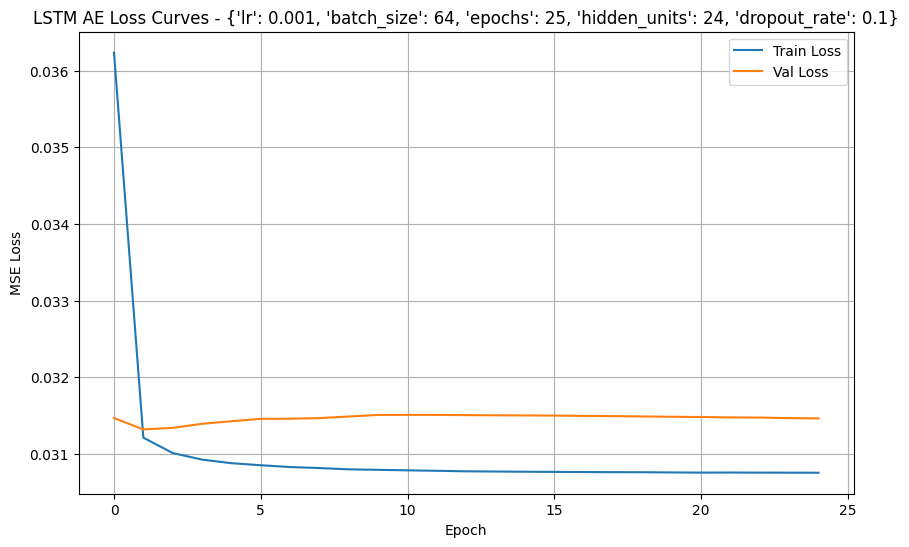


Testing LSTM AE with config: {'lr': 0.001, 'batch_size': 128, 'epochs': 10, 'hidden_units': 24, 'dropout_rate': 0.1}
LSTM AE | Epoch 1/10, Train Loss: 0.032344, Val Loss: 0.031987
LSTM AE | Epoch 2/10, Train Loss: 0.031009, Val Loss: 0.031662
LSTM AE | Epoch 3/10, Train Loss: 0.030948, Val Loss: 0.031502
LSTM AE | Epoch 4/10, Train Loss: 0.030918, Val Loss: 0.031373
LSTM AE | Epoch 5/10, Train Loss: 0.030889, Val Loss: 0.031268
LSTM AE | Epoch 6/10, Train Loss: 0.030866, Val Loss: 0.031191
LSTM AE | Epoch 7/10, Train Loss: 0.030845, Val Loss: 0.031132
LSTM AE | Epoch 8/10, Train Loss: 0.030829, Val Loss: 0.031081
LSTM AE | Epoch 9/10, Train Loss: 0.030817, Val Loss: 0.031044
LSTM AE | Epoch 10/10, Train Loss: 0.030808, Val Loss: 0.031021


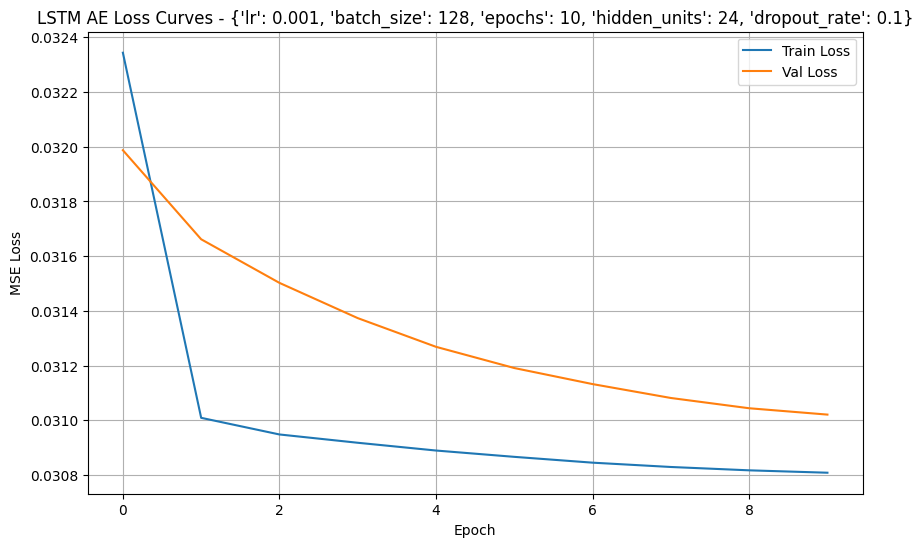


Testing LSTM AE with config: {'lr': 0.1, 'batch_size': 32, 'epochs': 25, 'hidden_units': 16, 'dropout_rate': 0.3}
LSTM AE | Epoch 1/25, Train Loss: 0.031773, Val Loss: 0.030443
LSTM AE | Epoch 2/25, Train Loss: 0.031079, Val Loss: 0.030450
LSTM AE | Epoch 3/25, Train Loss: 0.031087, Val Loss: 0.030457
LSTM AE | Epoch 4/25, Train Loss: 0.031090, Val Loss: 0.030460
LSTM AE | Epoch 5/25, Train Loss: 0.031092, Val Loss: 0.030463
LSTM AE | Epoch 6/25, Train Loss: 0.031093, Val Loss: 0.030464
LSTM AE | Epoch 7/25, Train Loss: 0.031094, Val Loss: 0.030465
LSTM AE | Epoch 8/25, Train Loss: 0.031094, Val Loss: 0.030466
LSTM AE | Epoch 9/25, Train Loss: 0.031095, Val Loss: 0.030467
LSTM AE | Epoch 10/25, Train Loss: 0.031095, Val Loss: 0.030467
LSTM AE | Epoch 11/25, Train Loss: 0.031095, Val Loss: 0.030467
LSTM AE | Epoch 12/25, Train Loss: 0.031095, Val Loss: 0.030468
LSTM AE | Epoch 13/25, Train Loss: 0.031095, Val Loss: 0.030468
LSTM AE | Epoch 14/25, Train Loss: 0.031095, Val Loss: 0.03046

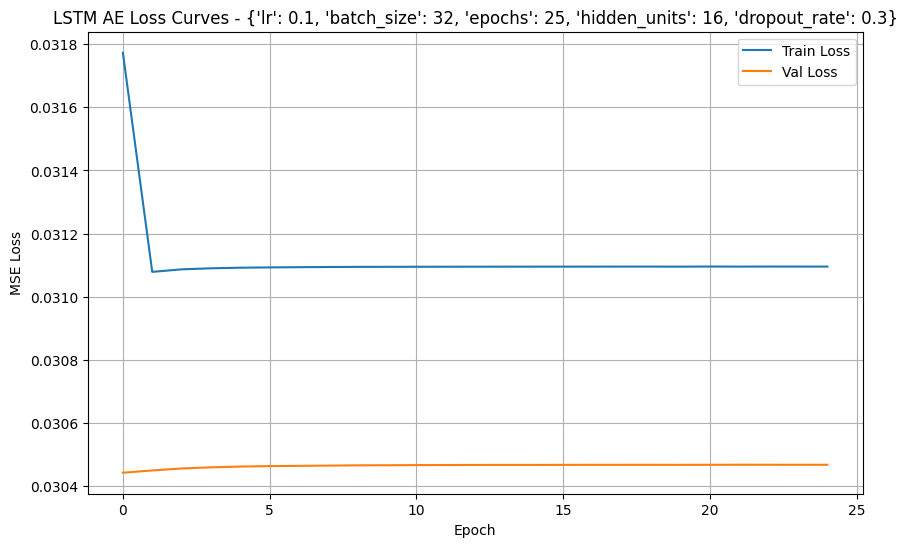


Tuning Conv1D AE

Testing Conv1D AE with config: {'lr': 0.1, 'batch_size': 128, 'epochs': 25, 'dropout_rate': 0.3}
Conv1D AE | Epoch 1/25, Train Loss: 0.032733, Val Loss: 0.030423
Conv1D AE | Epoch 2/25, Train Loss: 0.031068, Val Loss: 0.030433
Conv1D AE | Epoch 3/25, Train Loss: 0.031139, Val Loss: 0.030403
Conv1D AE | Epoch 4/25, Train Loss: 0.031158, Val Loss: 0.030391
Conv1D AE | Epoch 5/25, Train Loss: 0.031166, Val Loss: 0.030386
Conv1D AE | Epoch 6/25, Train Loss: 0.031171, Val Loss: 0.030383
Conv1D AE | Epoch 7/25, Train Loss: 0.031175, Val Loss: 0.030381
Conv1D AE | Epoch 8/25, Train Loss: 0.031178, Val Loss: 0.030380
Conv1D AE | Epoch 9/25, Train Loss: 0.031179, Val Loss: 0.030379
Conv1D AE | Epoch 10/25, Train Loss: 0.031181, Val Loss: 0.030378
Conv1D AE | Epoch 11/25, Train Loss: 0.031182, Val Loss: 0.030378
Conv1D AE | Epoch 12/25, Train Loss: 0.031183, Val Loss: 0.030377
Conv1D AE | Epoch 13/25, Train Loss: 0.031184, Val Loss: 0.030377
Conv1D AE | Epoch 14/25, Train Loss

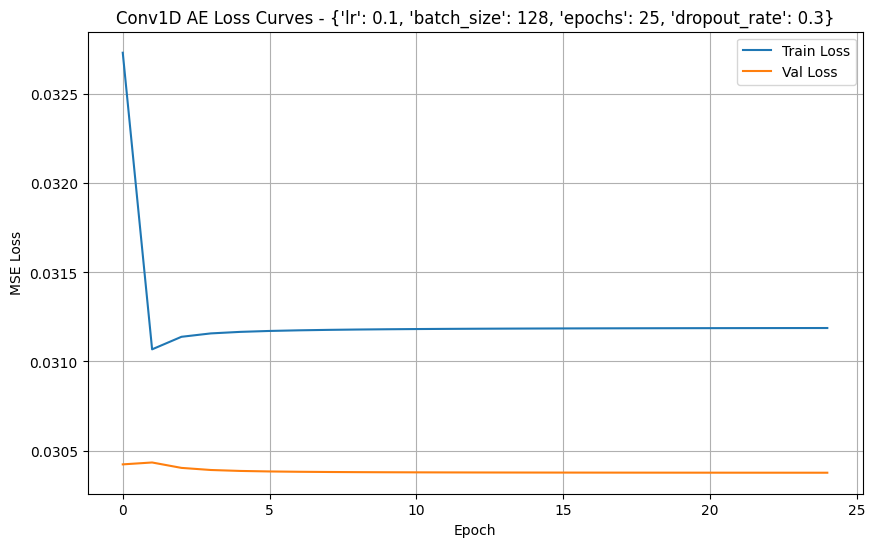


Testing Conv1D AE with config: {'lr': 0.001, 'batch_size': 64, 'epochs': 10, 'dropout_rate': 0.1}
Conv1D AE | Epoch 1/10, Train Loss: 0.031187, Val Loss: 0.021187
Conv1D AE | Epoch 2/10, Train Loss: 0.008548, Val Loss: 0.003384
Conv1D AE | Epoch 3/10, Train Loss: 0.003397, Val Loss: 0.002590
Conv1D AE | Epoch 4/10, Train Loss: 0.002497, Val Loss: 0.001622
Conv1D AE | Epoch 5/10, Train Loss: 0.001963, Val Loss: 0.001443
Conv1D AE | Epoch 6/10, Train Loss: 0.001782, Val Loss: 0.001209
Conv1D AE | Epoch 7/10, Train Loss: 0.001680, Val Loss: 0.001161
Conv1D AE | Epoch 8/10, Train Loss: 0.001588, Val Loss: 0.001158
Conv1D AE | Epoch 9/10, Train Loss: 0.001512, Val Loss: 0.001148
Conv1D AE | Epoch 10/10, Train Loss: 0.001441, Val Loss: 0.001084


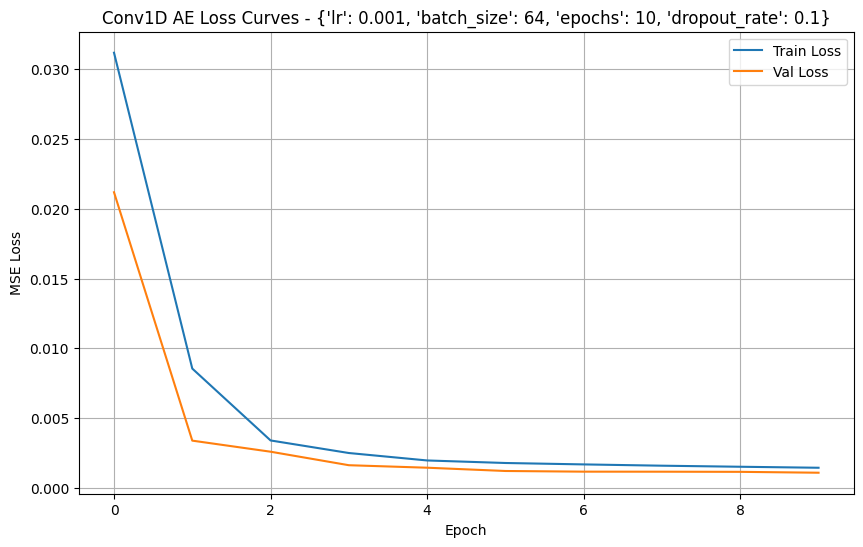


Testing Conv1D AE with config: {'lr': 0.001, 'batch_size': 32, 'epochs': 10, 'dropout_rate': 0.1}
Conv1D AE | Epoch 1/10, Train Loss: 0.019010, Val Loss: 0.004696
Conv1D AE | Epoch 2/10, Train Loss: 0.003875, Val Loss: 0.003002
Conv1D AE | Epoch 3/10, Train Loss: 0.002694, Val Loss: 0.002281
Conv1D AE | Epoch 4/10, Train Loss: 0.002104, Val Loss: 0.001879
Conv1D AE | Epoch 5/10, Train Loss: 0.001699, Val Loss: 0.001497
Conv1D AE | Epoch 6/10, Train Loss: 0.001445, Val Loss: 0.001374
Conv1D AE | Epoch 7/10, Train Loss: 0.001328, Val Loss: 0.001106
Conv1D AE | Epoch 8/10, Train Loss: 0.001238, Val Loss: 0.000969
Conv1D AE | Epoch 9/10, Train Loss: 0.001172, Val Loss: 0.000911
Conv1D AE | Epoch 10/10, Train Loss: 0.001111, Val Loss: 0.000848


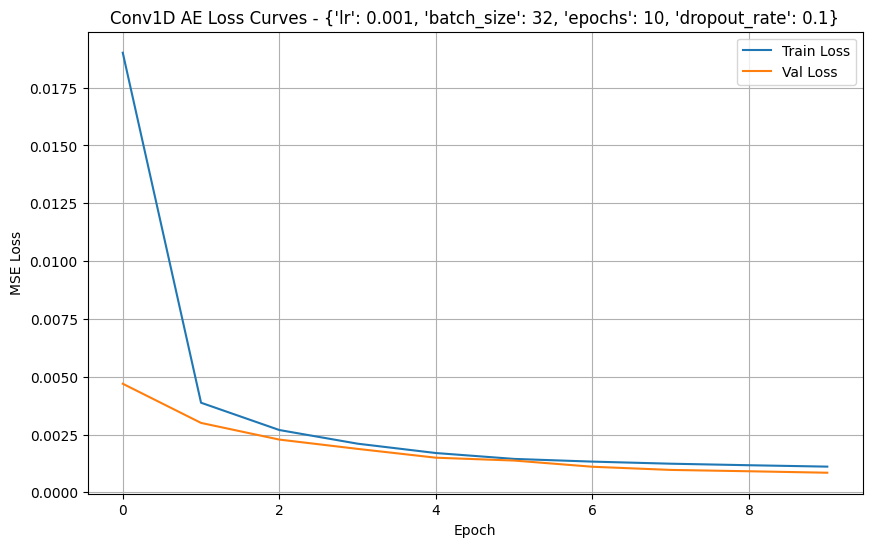


Testing Conv1D AE with config: {'lr': 0.1, 'batch_size': 32, 'epochs': 10, 'dropout_rate': 0.1}
Conv1D AE | Epoch 1/10, Train Loss: 0.004588, Val Loss: 0.002788
Conv1D AE | Epoch 2/10, Train Loss: 0.003397, Val Loss: 0.002583
Conv1D AE | Epoch 3/10, Train Loss: 0.003134, Val Loss: 0.011136
Conv1D AE | Epoch 4/10, Train Loss: 0.003196, Val Loss: 0.001740
Conv1D AE | Epoch 5/10, Train Loss: 0.002632, Val Loss: 0.001945
Conv1D AE | Epoch 6/10, Train Loss: 0.002645, Val Loss: 0.003781
Conv1D AE | Epoch 7/10, Train Loss: 0.002731, Val Loss: 0.002456
Conv1D AE | Epoch 8/10, Train Loss: 0.002848, Val Loss: 0.001952
Conv1D AE | Epoch 9/10, Train Loss: 0.002456, Val Loss: 0.001752
Conv1D AE | Epoch 10/10, Train Loss: 0.003040, Val Loss: 0.004585


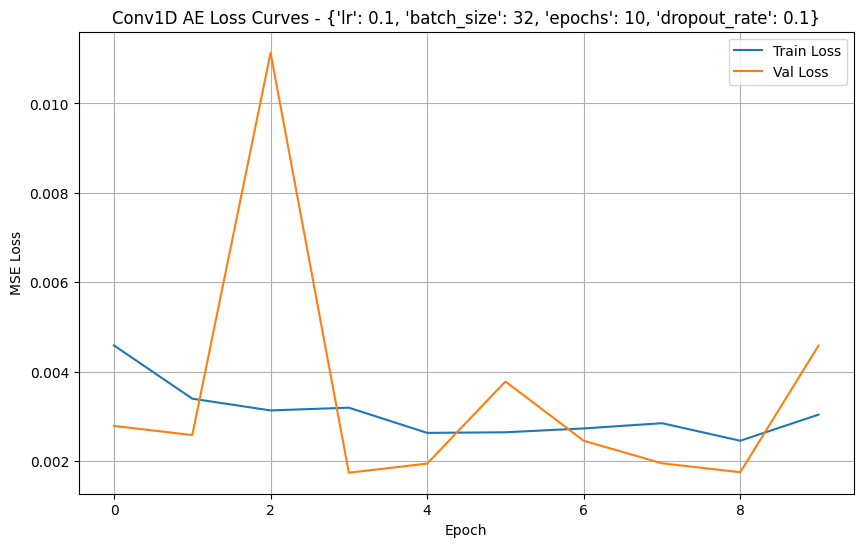


Testing Conv1D AE with config: {'lr': 0.1, 'batch_size': 64, 'epochs': 50, 'dropout_rate': 0.3}
Conv1D AE | Epoch 1/50, Train Loss: 0.013409, Val Loss: 0.006110
Conv1D AE | Epoch 2/50, Train Loss: 0.010696, Val Loss: 0.006607
Conv1D AE | Epoch 3/50, Train Loss: 0.010978, Val Loss: 0.006111
Conv1D AE | Epoch 4/50, Train Loss: 0.010290, Val Loss: 0.005422
Conv1D AE | Epoch 5/50, Train Loss: 0.010096, Val Loss: 0.005422
Conv1D AE | Epoch 6/50, Train Loss: 0.009681, Val Loss: 0.005297
Conv1D AE | Epoch 7/50, Train Loss: 0.009038, Val Loss: 0.004924
Conv1D AE | Epoch 8/50, Train Loss: 0.010202, Val Loss: 0.005080
Conv1D AE | Epoch 9/50, Train Loss: 0.009069, Val Loss: 0.006264
Conv1D AE | Epoch 10/50, Train Loss: 0.009785, Val Loss: 0.006492
Conv1D AE | Epoch 11/50, Train Loss: 0.009693, Val Loss: 0.005311
Conv1D AE | Epoch 12/50, Train Loss: 0.009963, Val Loss: 0.004740
Conv1D AE | Epoch 13/50, Train Loss: 0.008737, Val Loss: 0.004848
Conv1D AE | Epoch 14/50, Train Loss: 0.008735, Val Los

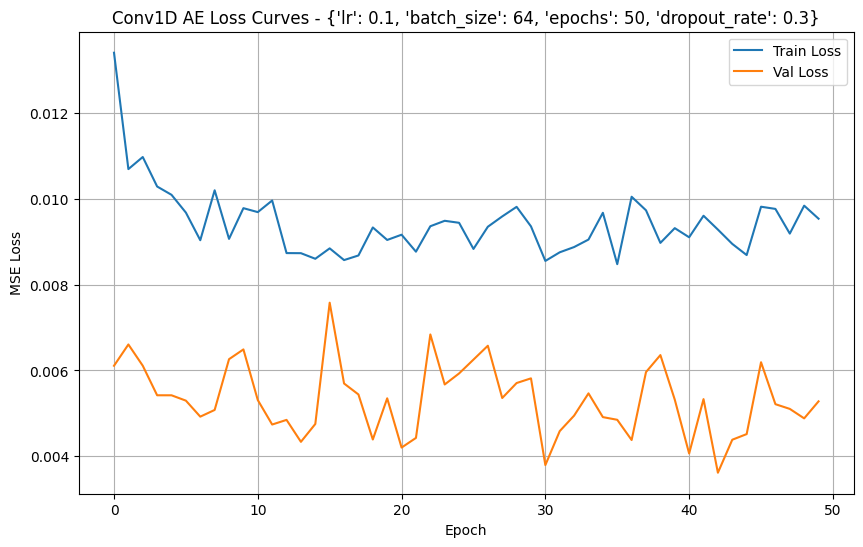


Testing Conv1D AE with config: {'lr': 0.001, 'batch_size': 32, 'epochs': 50, 'dropout_rate': 0.1}
Conv1D AE | Epoch 1/50, Train Loss: 0.012957, Val Loss: 0.002652
Conv1D AE | Epoch 2/50, Train Loss: 0.003128, Val Loss: 0.001706
Conv1D AE | Epoch 3/50, Train Loss: 0.002078, Val Loss: 0.001391
Conv1D AE | Epoch 4/50, Train Loss: 0.001695, Val Loss: 0.001130
Conv1D AE | Epoch 5/50, Train Loss: 0.001503, Val Loss: 0.000969
Conv1D AE | Epoch 6/50, Train Loss: 0.001364, Val Loss: 0.000888
Conv1D AE | Epoch 7/50, Train Loss: 0.001258, Val Loss: 0.000807
Conv1D AE | Epoch 8/50, Train Loss: 0.001167, Val Loss: 0.000788
Conv1D AE | Epoch 9/50, Train Loss: 0.001116, Val Loss: 0.000810
Conv1D AE | Epoch 10/50, Train Loss: 0.001049, Val Loss: 0.000757
Conv1D AE | Epoch 11/50, Train Loss: 0.001013, Val Loss: 0.000757
Conv1D AE | Epoch 12/50, Train Loss: 0.000982, Val Loss: 0.000709
Conv1D AE | Epoch 13/50, Train Loss: 0.000952, Val Loss: 0.000670
Conv1D AE | Epoch 14/50, Train Loss: 0.000928, Val L

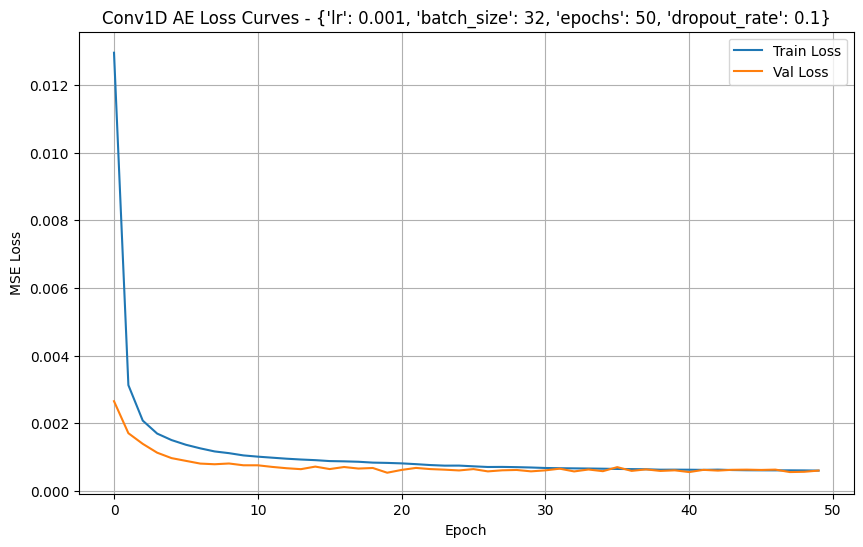


Testing Conv1D AE with config: {'lr': 0.01, 'batch_size': 128, 'epochs': 10, 'dropout_rate': 0.3}
Conv1D AE | Epoch 1/10, Train Loss: 0.010333, Val Loss: 0.005613
Conv1D AE | Epoch 2/10, Train Loss: 0.003595, Val Loss: 0.003582
Conv1D AE | Epoch 3/10, Train Loss: 0.003173, Val Loss: 0.003167
Conv1D AE | Epoch 4/10, Train Loss: 0.002951, Val Loss: 0.002942
Conv1D AE | Epoch 5/10, Train Loss: 0.002767, Val Loss: 0.002921
Conv1D AE | Epoch 6/10, Train Loss: 0.002723, Val Loss: 0.002619
Conv1D AE | Epoch 7/10, Train Loss: 0.002623, Val Loss: 0.002757
Conv1D AE | Epoch 8/10, Train Loss: 0.002529, Val Loss: 0.002772
Conv1D AE | Epoch 9/10, Train Loss: 0.002456, Val Loss: 0.002389
Conv1D AE | Epoch 10/10, Train Loss: 0.002423, Val Loss: 0.003018


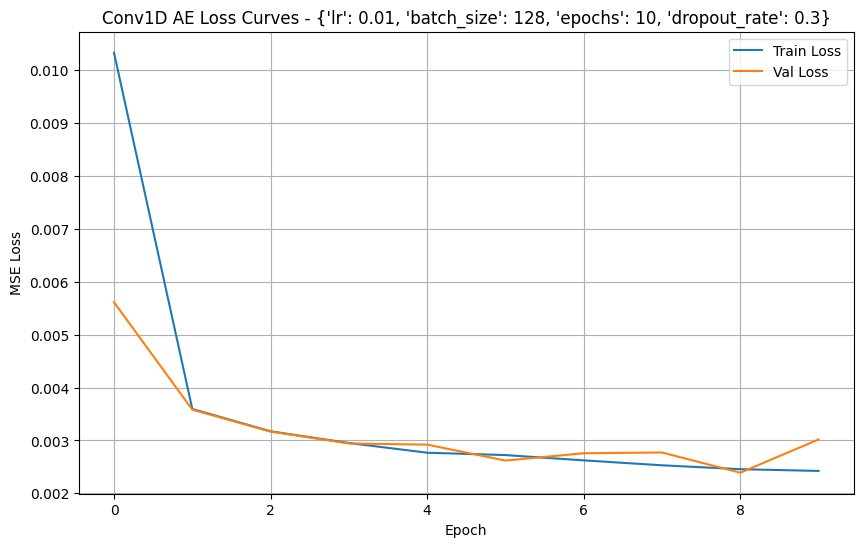


Testing Conv1D AE with config: {'lr': 0.01, 'batch_size': 32, 'epochs': 25, 'dropout_rate': 0.2}
Conv1D AE | Epoch 1/25, Train Loss: 0.004322, Val Loss: 0.003063
Conv1D AE | Epoch 2/25, Train Loss: 0.001861, Val Loss: 0.002251
Conv1D AE | Epoch 3/25, Train Loss: 0.001557, Val Loss: 0.002673
Conv1D AE | Epoch 4/25, Train Loss: 0.001463, Val Loss: 0.001932
Conv1D AE | Epoch 5/25, Train Loss: 0.001401, Val Loss: 0.001820
Conv1D AE | Epoch 6/25, Train Loss: 0.001385, Val Loss: 0.001407
Conv1D AE | Epoch 7/25, Train Loss: 0.001336, Val Loss: 0.001368
Conv1D AE | Epoch 8/25, Train Loss: 0.001342, Val Loss: 0.002327
Conv1D AE | Epoch 9/25, Train Loss: 0.001342, Val Loss: 0.002225
Conv1D AE | Epoch 10/25, Train Loss: 0.001362, Val Loss: 0.001834
Conv1D AE | Epoch 11/25, Train Loss: 0.001301, Val Loss: 0.002138
Conv1D AE | Epoch 12/25, Train Loss: 0.001317, Val Loss: 0.002430
Conv1D AE | Epoch 13/25, Train Loss: 0.001309, Val Loss: 0.001853
Conv1D AE | Epoch 14/25, Train Loss: 0.001284, Val Lo

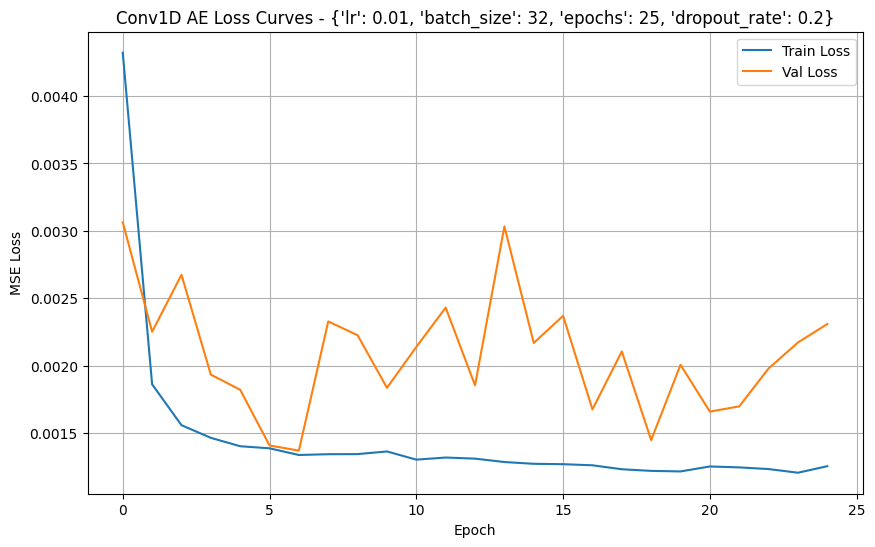


Testing Conv1D AE with config: {'lr': 0.1, 'batch_size': 32, 'epochs': 50, 'dropout_rate': 0.1}
Conv1D AE | Epoch 1/50, Train Loss: 0.011386, Val Loss: 0.007186
Conv1D AE | Epoch 2/50, Train Loss: 0.007859, Val Loss: 0.004681
Conv1D AE | Epoch 3/50, Train Loss: 0.007753, Val Loss: 0.008919
Conv1D AE | Epoch 4/50, Train Loss: 0.007781, Val Loss: 0.004589
Conv1D AE | Epoch 5/50, Train Loss: 0.007673, Val Loss: 0.004408
Conv1D AE | Epoch 6/50, Train Loss: 0.007862, Val Loss: 0.007457
Conv1D AE | Epoch 7/50, Train Loss: 0.007827, Val Loss: 0.003912
Conv1D AE | Epoch 8/50, Train Loss: 0.007682, Val Loss: 0.003911
Conv1D AE | Epoch 9/50, Train Loss: 0.007709, Val Loss: 0.006000
Conv1D AE | Epoch 10/50, Train Loss: 0.007877, Val Loss: 0.006130
Conv1D AE | Epoch 11/50, Train Loss: 0.007518, Val Loss: 0.004510
Conv1D AE | Epoch 12/50, Train Loss: 0.007683, Val Loss: 0.005361
Conv1D AE | Epoch 13/50, Train Loss: 0.007907, Val Loss: 0.006335
Conv1D AE | Epoch 14/50, Train Loss: 0.007742, Val Los

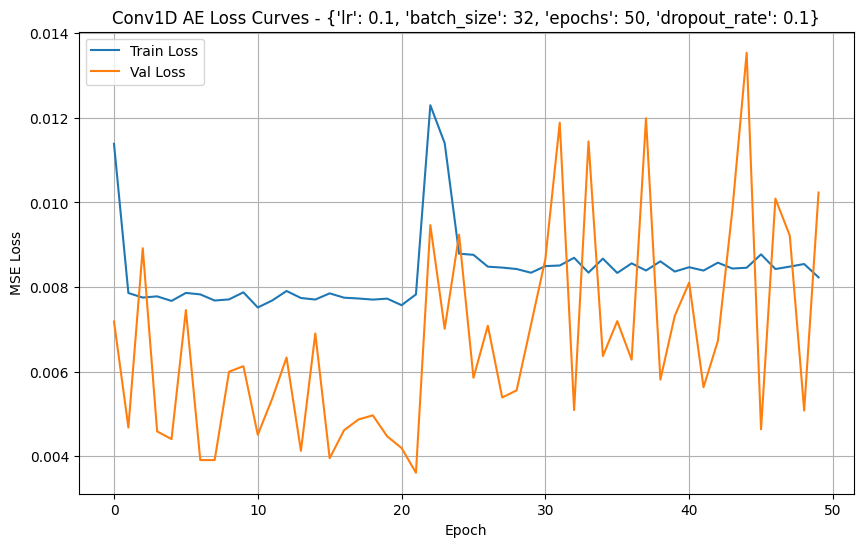


Testing Conv1D AE with config: {'lr': 0.1, 'batch_size': 32, 'epochs': 50, 'dropout_rate': 0.1}
Conv1D AE | Epoch 1/50, Train Loss: 0.031572, Val Loss: 0.030469
Conv1D AE | Epoch 2/50, Train Loss: 0.031100, Val Loss: 0.030469
Conv1D AE | Epoch 3/50, Train Loss: 0.031098, Val Loss: 0.030468
Conv1D AE | Epoch 4/50, Train Loss: 0.031097, Val Loss: 0.030468
Conv1D AE | Epoch 5/50, Train Loss: 0.031097, Val Loss: 0.030468
Conv1D AE | Epoch 6/50, Train Loss: 0.031096, Val Loss: 0.030468
Conv1D AE | Epoch 7/50, Train Loss: 0.031096, Val Loss: 0.030468
Conv1D AE | Epoch 8/50, Train Loss: 0.031096, Val Loss: 0.030468
Conv1D AE | Epoch 9/50, Train Loss: 0.031096, Val Loss: 0.030468
Conv1D AE | Epoch 10/50, Train Loss: 0.031096, Val Loss: 0.030468
Conv1D AE | Epoch 11/50, Train Loss: 0.031096, Val Loss: 0.030468
Conv1D AE | Epoch 12/50, Train Loss: 0.031096, Val Loss: 0.030468
Conv1D AE | Epoch 13/50, Train Loss: 0.031096, Val Loss: 0.030468
Conv1D AE | Epoch 14/50, Train Loss: 0.031096, Val Los

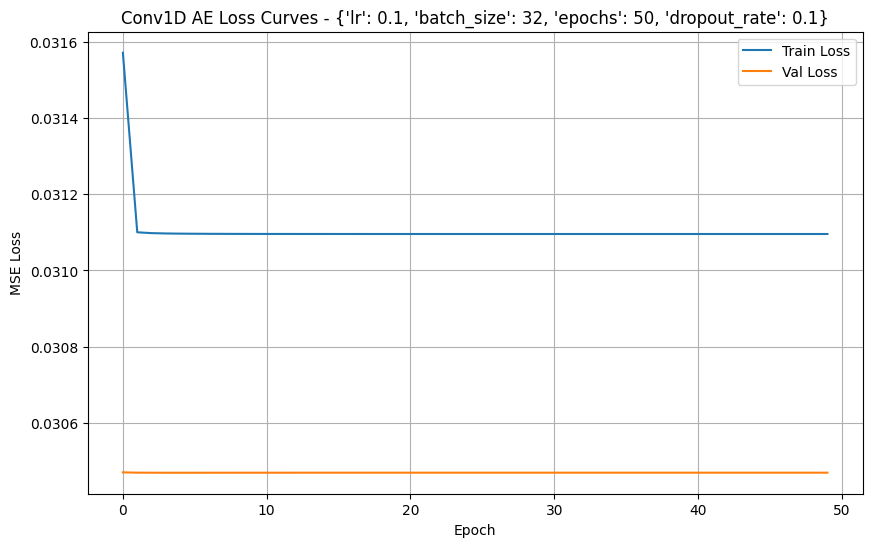


Overall Best Model: Conv1D AE
Validation Loss: 0.000537
Hyperparameters: {'lr': 0.001, 'batch_size': 32, 'epochs': 50, 'dropout_rate': 0.1}


In [ ]:
def train_and_tune(model, train_data, val_data, model_name, hyperparams):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=hyperparams['batch_size'], shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=hyperparams['batch_size'], shuffle=False)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=hyperparams['lr'])
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None
    for epoch in range(hyperparams['epochs']):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                output = model(batch)
                val_loss += criterion(output, batch).item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
        print(f"{model_name} | Epoch {epoch+1}/{hyperparams['epochs']}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(model.state_dict())
    return train_losses, val_losses, best_val_loss, best_model_state


lr_options = [0.001, 0.01, 0.1]
batch_size_options = [32, 64, 128]
epochs_options = [10, 25, 50]
hidden_units_options = [8, 16, 24]
dropout_rate_options = [0.1, 0.2, 0.3]
all_results = []
model_classes = [(DenseAutoencoder, "Dense AE"), (LSTMAutoencoder, "LSTM AE"), (Conv1DAutoencoder, "Conv1D AE")]
for model_class, model_name in model_classes:
    print(f"\nTuning {model_name}")
    if model_name == "Conv1D AE":
        configs = [dict(lr=random.choice(lr_options), batch_size=random.choice(batch_size_options),
                        epochs=random.choice(epochs_options), dropout_rate=random.choice(dropout_rate_options))
                   for _ in range(10)]
    else:
        configs = [dict(lr=random.choice(lr_options), batch_size=random.choice(batch_size_options),
                        epochs=random.choice(epochs_options), hidden_units=random.choice(hidden_units_options),
                        dropout_rate=random.choice(dropout_rate_options))
                   for _ in range(10)]
    for config in configs:
        print(f"\nTesting {model_name} with config: {config}")
        if model_name == "Dense AE":
            model = model_class(input_size=48, hidden_units=config['hidden_units'], dropout_rate=config['dropout_rate']).to(device)
        elif model_name == "LSTM AE":
            model = model_class(input_size=1, hidden_size=config['hidden_units'], num_layers=2, dropout_rate=config['dropout_rate']).to(device)
        else:
            model = model_class(dropout_rate=config['dropout_rate']).to(device)
        train_losses, val_losses, val_loss, model_state = train_and_tune(model, X_train_tensor, X_val_tensor, model_name, config)
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.title(f"{model_name} Loss Curves - {config}")
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
        all_results.append({
            'model_name': model_name,
            'val_loss': val_loss,
            'hyperparams': config,
            'state': model_state
        })

best_result = min(all_results, key=lambda x: x['val_loss'])
best_model_name = best_result['model_name']
best_val_loss = best_result['val_loss']
best_hyperparams = best_result['hyperparams']
best_model_state = best_result['state']
print(f"\nOverall Best Model: {best_model_name}")
print(f"Validation Loss: {best_val_loss:.6f}")
print(f"Hyperparameters: {best_hyperparams}")

4. Save the weights of the trained neural network that provides the best results. Check saving and loading models (PyTorch)

In [ ]:
best_model_filename = f"best_model_{best_model_name.replace(' ', '_')}.pth"
torch.save(best_model_state, best_model_filename)
print(f"Saved best model ({best_model_name}) weights to {best_model_filename}")

Saved best model (Conv1D AE) weights to best_model_Conv1D_AE.pth


## Step 3: Evaluation and analysis

1. Evaluate your best model on the test set. Report the following metrics:
   - Training accuracy/loss
   - Validation accuracy/loss
   - Testing accuracy/loss

In [ ]:
if best_model_name == "Dense AE":
    best_model = DenseAutoencoder(input_size=48, hidden_units=best_hyperparams['hidden_units'], dropout_rate=best_hyperparams['dropout_rate']).to(device)
elif best_model_name == "LSTM AE":
    best_model = LSTMAutoencoder(input_size=1, hidden_size=best_hyperparams['hidden_units'], num_layers=2, dropout_rate=best_hyperparams['dropout_rate']).to(device)
else:
    best_model = Conv1DAutoencoder(dropout_rate=best_hyperparams['dropout_rate']).to(device)
best_model.load_state_dict(torch.load(best_model_filename))
best_model.eval()
print(f"Loaded best model: {best_model_name} from {best_model_filename}")


def evaluate_model(model, data, batch_size=best_hyperparams['batch_size']):
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False)
    original = []
    reconstructed = []
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            output = model(batch)
            original.extend(batch.cpu().numpy())
            reconstructed.extend(output.cpu().numpy())
    original = np.array(original).reshape(-1)
    reconstructed = np.array(reconstructed).reshape(-1)
    mae = mean_absolute_error(original, reconstructed)
    rmse = np.sqrt(mean_squared_error(original, reconstructed))
    r2 = r2_score(original, reconstructed)
    mse = mean_squared_error(original, reconstructed)
    return mse, mae, rmse, r2


train_mse, train_mae, train_rmse, train_r2 = evaluate_model(best_model, X_train_tensor)
val_mse, val_mae, val_rmse, val_r2 = evaluate_model(best_model, X_val_tensor)
test_mse, test_mae, test_rmse, test_r2 = evaluate_model(best_model, X_test_tensor)
print(f"\nEvaluation Results for Best Model ({best_model_name}):")
print(f"Training Loss (MSE): {train_mse:.6f}")
print(f"Validation Loss (MSE): {val_mse:.6f}")
print(f"Testing Loss (MSE): {test_mse:.6f}")

Loaded best model: Conv1D AE from best_model_Conv1D_AE.pth

Evaluation Results for Best Model (Conv1D AE):
Training Loss (MSE): 0.000571
Validation Loss (MSE): 0.000541
Testing Loss (MSE): 0.000683


2. Depending on your chosen dataset, report relevant metrics like:
   - Regression: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), R-squared (coefficient of determination). Use sklearn.metrics.
   - Classification: Precision, Recall, F1-score.

In [ ]:
print(f"\nEvaluation Results for Best Model ({best_model_name}):")
print("Training Metrics:")
print(f"  MAE: {train_mae:.6f}")
print(f"  RMSE: {train_rmse:.6f}")
print(f"  R²: {train_r2:.6f}")
print("Validation Metrics:")
print(f"  MAE: {val_mae:.6f}")
print(f"  RMSE: {val_rmse:.6f}")
print(f"  R²: {val_r2:.6f}")
print("Testing Metrics:")
print(f"  MAE: {test_mae:.6f}")
print(f"  RMSE: {test_rmse:.6f}")
print(f"  R²: {test_r2:.6f}")


Evaluation Results for Best Model (Conv1D AE):
Training Metrics:
  MAE: 0.018755
  RMSE: 0.023905
  R²: 0.981349
Validation Metrics:
  MAE: 0.018905
  RMSE: 0.023249
  R²: 0.982283
Testing Metrics:
  MAE: 0.020681
  RMSE: 0.026127
  R²: 0.980112


3. Provide the following plots:
   - Plot training and validation accuracy/loss curves over epochs.
   - Plot the distribution of the reconstruction errors (i.e., differences between input and output data points).


Re-training Conv1D AE to capture loss history:
Epoch 1/50, Train Loss: 0.000808, Val Loss: 0.000630
Epoch 2/50, Train Loss: 0.000789, Val Loss: 0.000634
Epoch 3/50, Train Loss: 0.000761, Val Loss: 0.000655
Epoch 4/50, Train Loss: 0.000748, Val Loss: 0.000682
Epoch 5/50, Train Loss: 0.000734, Val Loss: 0.000679
Epoch 6/50, Train Loss: 0.000717, Val Loss: 0.000594
Epoch 7/50, Train Loss: 0.000715, Val Loss: 0.000670
Epoch 8/50, Train Loss: 0.000698, Val Loss: 0.000654
Epoch 9/50, Train Loss: 0.000697, Val Loss: 0.000674
Epoch 10/50, Train Loss: 0.000682, Val Loss: 0.000564
Epoch 11/50, Train Loss: 0.000678, Val Loss: 0.000598
Epoch 12/50, Train Loss: 0.000666, Val Loss: 0.000582
Epoch 13/50, Train Loss: 0.000668, Val Loss: 0.000617
Epoch 14/50, Train Loss: 0.000659, Val Loss: 0.000622
Epoch 15/50, Train Loss: 0.000669, Val Loss: 0.000541
Epoch 16/50, Train Loss: 0.000655, Val Loss: 0.000563
Epoch 17/50, Train Loss: 0.000642, Val Loss: 0.000627
Epoch 18/50, Train Loss: 0.000638, Val Loss

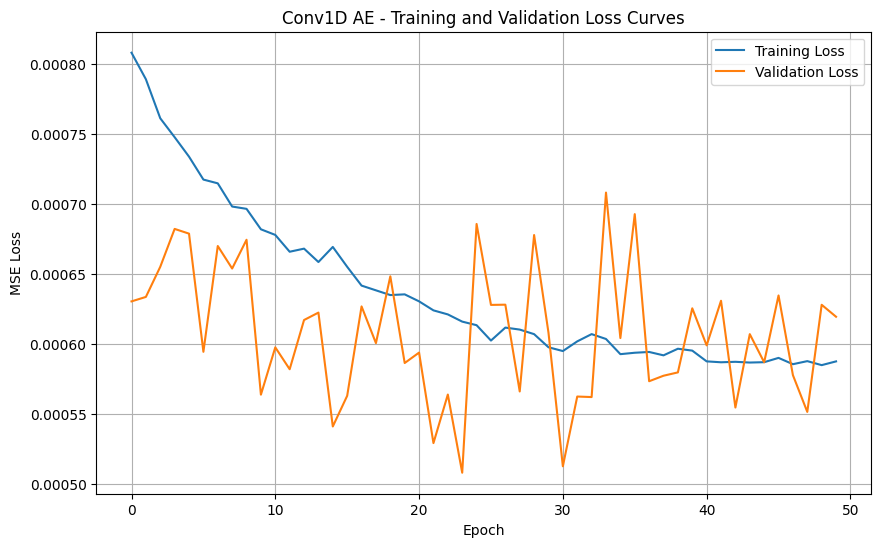

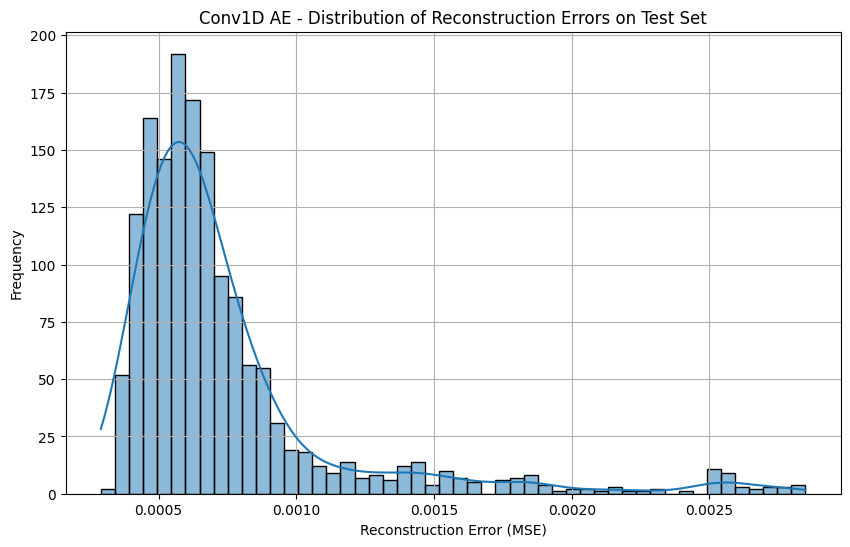

In [ ]:
def train_and_capture_losses(model, train_data, val_data, hyperparams):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=hyperparams['batch_size'], shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=hyperparams['batch_size'], shuffle=False)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=hyperparams['lr'])
    train_losses, val_losses = [], []
    for epoch in range(hyperparams['epochs']):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                output = model(batch)
                val_loss += criterion(output, batch).item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{hyperparams['epochs']}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    return train_losses, val_losses


print(f"\nRe-training {best_model_name} to capture loss history:")
train_losses, val_losses = train_and_capture_losses(best_model, X_train_tensor, X_val_tensor, best_hyperparams)
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f"{best_model_name} - Training and Validation Loss Curves")
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

def get_reconstruction_errors(model, test_data, batch_size=32):
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    errors = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            batch_errors = torch.mean((batch - output) ** 2, dim=1).cpu().numpy()
            errors.extend(batch_errors)
    return np.array(errors)


reconstruction_errors = get_reconstruction_errors(best_model, X_test_tensor, batch_size=best_hyperparams['batch_size'])
plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_errors, bins=50, kde=True)
plt.title(f"{best_model_name} - Distribution of Reconstruction Errors on Test Set")
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

4. Discuss and analyze:

   - Describe your final RNN/LSTM architecture in detail (number of layers, types of layers, hidden size, dropout rate, etc.).


##Type: Convolutional Autoencoder (1D)


1. **Layer 1: 1D Convolutional Layer (Conv1d)**  
   - **Input Channels**: 1  
   - **Output Channels**: 16
   - **Kernel Size**: 3  
   - **Padding**: 1  
   - **Output Shape**: (batch_size, 16, 48)

2. **Activation: ReLU**  
   - Applies the Rectified Linear Unit (ReLU) activation function.  

3. **Dropout**  
   - **Rate**: 0.1

4. **Layer 2: Max Pooling (MaxPool1d)**  
   - **Kernel Size**: 2  
   - **Stride**: 2  
   - **Output Shape**: (batch_size, 16, 24)

5. **Layer 3: 1D Convolutional Layer (Conv1d)**  
   - **Input Channels**: 16  
   - **Output Channels**: 8
   - **Kernel Size**: 3  
   - **Padding**: 1  
   - **Output Shape**: (batch_size, 8, 24)

6. **Activation: ReLU**  
   - Same as above, adding non-linearity.

7. **Dropout**  
   - **Rate**: 0.1  

8. **Layer 4: Max Pooling (MaxPool1d)**  
   - **Kernel Size**: 2  
   - **Stride**: 2  
   - **Output Shape**: (batch_size, 8, 12)
   - **Purpose**: Final downsampling, creating the latent representation.

### Decoder
The decoder reconstructs the original sequence from the latent representation.

1. **Layer 1: 1D Transposed Convolutional Layer (ConvTranspose1d)**  
   - **Input Channels**: 8
   - **Output Channels**: 16  
   - **Kernel Size**: 4  
   - **Stride**: 2  
   - **Padding**: 1  
   - **Output Shape**: (batch_size, 16, 24)

2. **Activation: ReLU**  

3. **Dropout**  
   - **Rate**: 0.1  

4. **Layer 2: 1D Transposed Convolutional Layer (ConvTranspose1d)**  
   - **Input Channels**: 16  
   - **Output Channels**: 1
   - **Kernel Size**: 4  
   - **Stride**: 2  
   - **Padding**: 1  
   - **Output Shape**: (batch_size, 1, 48)

5. **Activation: Sigmoid**  
   - **Output Range**: [0, 1]  

- **Final Output**: After squeezing the channel dimension (squeeze(1)), the output shape is (batch_size, 48), matching the input sequence length.

   - Discuss your results, referencing the metrics and visualizations. Did your model achieve the expected accuracy? What were the challenges? How did hyperparameter tuning affect performance? Are there any patterns in the errors (e.g., consistent under- or over-prediction)?

### 1. Training and Validation Loss Curves
- The training loss converges nicely, a sign of stable learning.
- The validation loss is less stable, having high spikes (e.g., at epochs 20 and 30) but eventually converges to the same values as the training loss. This fluctuation can be due to the smaller size of the validation set or sensitivity to specific patterns.
- There is no overfitting since validation loss does not diverge in the positive direction from train loss. Both losses become very close (0.000571 vs. 0.000541), as do the metrics.

### 2. Reconstruction Error Distribution
- Anomaly detection tasks need to have the right-skewed distribution: the majority of normal points will have infinitesimal reconstruction errors, while outliers will have higher errors.
- This can be seen in the KDE curve's steep peak around 0 and decreasing monotonically, and minor bump around the tail.

##Interpretions
- **Expectation**: In anomaly detection, we would prefer to see small reconstruction errors for normal instances and large errors for anomalies. Our model MSE (0.000683 on test), MAE (0.020681), and R² (0.980112) are all ideal and reconstruct normal patterns perfectly.
- **Outcome**: Yes, the model performed as expected. Both low loss and high R² are indicative of it having learned the NYC Taxi patterns effectively. Both the random search validation loss of 0.000537 and test loss of 0.000683 are very close to zero, as one would hope for in a performing autoencoder.

## Challenges
1. **Validation Loss Volatility**
- Validation loss curve is highest, and these peaks can be attributed to sensitivity to some validation samples or small validation set size causing greater variance in loss.
2. **Possible Test Set Anomalies:**
- The long tail in the reconstruction error distribution shows that there are test samples with greater errors. They are usually anomalies, but without ground-truth labels, one cannot say.

## How Did Hyperparameter Tuning Affect Performance?
- **Impact:**
- **Learning Rate (0.001)**: Moderate rate allowing constant convergence, as was visible from the clutter-free training loss curve. High rate resulted in instability, while a low one could have resulted in slower convergence.
- **Batch Size (32)**: Trade-off between computational speed and stability of gradients. Small batch sizes will hopefully have noisier updates, while big ones have less frequent updates per epoch.
- **Epochs (50)**: Adequate for convergence since both training loss and validation loss converge towards the end. Additional epochs would not have indicated significant gain.
- **Dropout Rate (0.1)**: Low dropout rate prevented overfitting, as can be seen from the same training and validation losses. Overfitting might have been obtained with a lesser rate, and 0.0 might have overfitted.
- Hyperparameter tuning was significant in obtaining the lowest validation loss of 0.000537 across all models. Conv1D AE was better than the Dense and LSTM models since, being a superior capturer of local temporal patterns through convolutions, it did better.
## Error Patterns
- **Distribution of Reconstruction Error:**
- The right-skewed distribution would indicate that the great majority of samples are reconstructed with very small errors and a small minority with quite larger errors.
- **Under/Over-Prediction**: To be able to identify under- or over-prediction systematically, we would have to compute the signed difference on a sample-per-sample basis. The measures available (MSE, MAE) are unsigned, but what can be inferred from the distribution is:
- Most of the errors are close to 0, i.e., there is no systematic bias in most of the samples.

Discuss the strengths and limitations of using autoencoders for anomaly
detection.

# Autoencoder Advantages and Disadvantages for Anomaly Detection

Autoencoders work well for unsupervised anomaly detection, detecting anomalous patterns without labels. Their advantages and disadvantages are summarized below.

## Advantages
1. **No Labels Required**: Operates on no labeled data, optimal for rare anomalies.
2. **Complex Patterns**: Detects complex, non-linear data patterns very well.
3. **Error-Based Anomaly Detection**: Achieves high reconstruction errors to effectively detect anomalies.
4. **Lightweight**: Lightweight and scalable for big data.
5. **Flexible Design**: Can be used across different data types or applications.

## Disadvantages
1. **Verification Challenge**: Hard to check for anomalies without annotations.
2. **Setting Sensitivity**: Highly sensitive to moody-to-set parameters.
3. **Short-Term Focus**: Performs badly on long-term trends compared to other models.
4. **Subtle Anomalies**: Can miss subtle changes that appear as normal data.
5. **Threshold Difficulty**: Not easy to establish an error threshold for anomalies.


5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.



1. https://pandas.pydata.org/docs/
2. https://numpy.org/doc/stable/
3. https://pytorch.org/docs/stable/index.html
4. https://scikit-learn.org/stable/user_guide.html
5. https://matplotlib.org/
6. https://www.ibm.com/think/topics/autoencoder
7. https://arxiv.org/pdf/2003.05991
8. https://arxiv.org/pdf/1606.05908
9. https://www.geeksforgeeks.org/auto-encoders/
10. https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/
11. https://discuss.pytorch.org/t/lstm-autoencoders-in-pytorch/139727
12. https://pyimagesearch.com/2023/07/17/implementing-a-convolutional-autoencoder-with-pytorch/
13. https://discuss.pytorch.org/t/1d-convolutional-autoencoder/16433
14. https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
15. https://medium.com/@weidagang/demystifying-anomaly-detection-with-autoencoder-neural-networks-1e235840d879
16. https://www.analyticsvidhya.com/blog/2022/01/complete-guide-to-anomaly-detection-with-autoencoders-using-tensorflow/




6. If you are working in a team, provide a contribution summary.

| Team Member | Step# | Contribution (%) |
|---|---|---|
|  1 | Step 1 |  50% |
|  2 | Step 1 |   50%|
|   1| Step 2 |  50% |
|   2| Step 2 |  50% |
|   1| Step 3 |  50% |
|   2| Step 3 |   50%|
|   | **Total** |  100% |